In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%load_ext rpy2.ipython 

In [3]:
%%R
options(scipen=999) #Desactiva notación científica

In [ ]:
%%R
#Carga de paquetes simplificada con pacman
install.packages("pacman", quiet=TRUE)

pacman::p_load(dplyr,funModeling,countrycode,nortest,sjmisc,rcompanion,FSA,gmodels,vcd,DescTools,stats,ggplot2,pwr)

#Carga de datos y descripción del dataset

In [ ]:
%%R
salarios <- read.csv("/content/drive/MyDrive/Facultad/2do TUPED/EDM/Examen/Salarios.csv")

In [ ]:
%%R
dim(salarios)

In [ ]:
%%R
df_status(salarios)

**Conclusiones**:
El dataset está compuesto por 607 observaciones o datos. Un total de 12 variables, contando el id, el cuál seguramente será removido por no contener información relevante. En cuanto a la calidad del dataset, se observa que no contiene valores incorrectos y en cuanto a valores nulos estos sólo aparecen en la variable "remote_ratio" la cuál tiene como posible valor al cero, por lo cual no hay ningún inconveniente.


In [ ]:
%%R
str(salarios)

#Limpieza de datos

In [ ]:
%%R
salarios <- salarios[ , !names(salarios) %in% c("X","salary")]

Se quita la primer variable, que se supone es un ID, por no proveer información relevante, y la variable de salario en moneda local ya que resulta mejor a la hora del analisís usar el valor estandarizado en USD.

In [ ]:
%%R
describe(salarios)

Con una visión más detallada de los datos de cada variable se puede ver que en la mayoría de las variables cualitativas, "experience_level", "employment_type", "salary_currency", "remote_ratio", "company_size", los datos cargados corresponden a valores válidos.
Para las variables númericas "work_year" y "salary_in_usd" tampoco existen valores inválidos como por ejemplo un valor negativo.
Se considerará como variable cualitativa a "work_year" dado el contexto en el cual está siendo usada.

Las variables "employee_residence" y "company_location" se verán con más detalle ya que no se pueden apreciar todos los valores únicos del dataset para validar completamente todos los datos.

In [ ]:
%%R
unique(salarios$employee_residence)

In [ ]:
%%R
unique(salarios$company_location)

Para no tener que verificar esto de manera manual se utiliza el dataframe "codelist" del paquete "countrycode" que contiene los valores ISO posibles.

In [ ]:
%%R
valores_invalidos <- salarios[!(salarios$employee_residence %in% codelist$iso2c)]

print(valores_invalidos)

In [ ]:
%%R
valores_invalidos2 <- salarios[!(salarios$company_location %in% codelist$iso2c)]

print(valores_invalidos2)

Para la variable "job_title"

In [ ]:
%%R
unique(salarios$job_title)

No parece haber errores en estos datos

Finalmente se convierten las variables cualitativas a factores y se renombran las columnas con nombres más intuitivos en español.

In [ ]:
%%R
salarios$work_year <- as.factor(salarios$work_year)
salarios$experience_level   <- as.factor(salarios$experience_level)
salarios$employment_type   <- as.factor(salarios$employment_type)
salarios$job_title   <- as.factor(salarios$job_title)
salarios$salary_currency   <- as.factor(salarios$salary_currency)
salarios$employee_residence   <- as.factor(salarios$employee_residence)
salarios$remote_ratio   <- as.factor(salarios$remote_ratio)
salarios$company_location   <- as.factor(salarios$company_location)
salarios$company_size   <- as.factor(salarios$company_size)
colnames(salarios) <- c("año_trabajado","nivel_experiencia","tipo_empleo","cargo","moneda_remunerada","salario_usd",
                        "residencia_empleado","ratio_trabajo_remoto","sede_empresa","tamaño_empresa")
str(salarios)

#Pre analisis

**Año trabajado**: Al estar los datos correspondidos entre 2020,2021 y 2022 se espera que dado el contexto de pandemia que ocurrió por esas épocas, está variable afecte a los salarios en cierta medida.

**Nivel de experiencia**: Está variable puede tener relación fuerte con el salario ya que por lo general los trabajadores más experimentados suelen recibir una mayor remuneración por sus servicios.

Tipo de empleo: En cuanto al tipo de empleo, puede estar relacionado ligeramente al salario por ejemplo en el caso de los trabajadores a contrato o freelance con respecto a los trabajadores permanentes ya que realizan trabajos por periodos de tiempo cortos y deben cobrar más para asegurar su bienestar.

**Cargo**: Se espera que está variable tenga una fuerte relación respecto al salario ya que la importancia de la posición ocupada dentro de una empresa suele ser un gran indicador en las diferencias salariales.

**Moneda remunerada**: La variable puede tener alta relación con el salario aunque no necesariamente de manera directa, sino más bien indirectamente debido a que el tipo de moneda es afectado por el lugar de residencia del empleado donde los costos de vida pueden variar en los distintos países. Sin embargo, no puede ser descartada ya que puede ocurrir que la moneda remunerada por un empleado no sea la misma que se utiliza en su país de residencia.

**Salario en USD**: La variable más importante del dataset, la cuál indica el equivalente del salario de cada trabajador unificado en dólares para permitir la comparación entre trabajadores que reciben su remuneración en monedas diferentes.

**Residencia empleado**: La variable puede estar moderadamente relacionada al salario ya que, como se mencionó previamente, en cada país los costos de vida pueden variar y el trabajador puede exigir un mayor salario.

**Ratio de trabajo remoto**: Es posible que la variable esté ligeramente relacionada al salario ya que puede ocurrir que un trabajador que realiza su trabajo de manera presencial requiere un mayor salario para costear, por ejemplo, transporte.
Sede de la empresa: Está variable debería impactar moderadamente al salario ya que dependiendo la sede de la empresa los mercados de los distintos países pueden ser diferentes.

**Tamaño de la empresa**: La cantidad de trabajadores de la empresa puede afectar en cierta medida al salario de los mismos ya que puede ocurrir que una empresa pequeña tenga pocos trabajadores mejores pagados en un área, o en una empresa grande muchos trabajadores con un salario promedio.

Asiganando un valor de prioridad del 1 al 10 se puede expresar gráficamente como puede afectar cada variable al salario

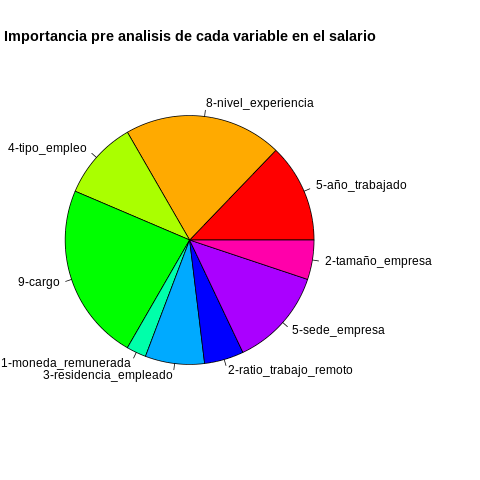

In [ ]:
%%R
par(mar=c(5,0,5,7))
prioridad = c(5,8,4,9,1,3,2,5,2)
pie(x = prioridad,
    labels = c("5-año_trabajado","8-nivel_experiencia","4-tipo_empleo","9-cargo","1-moneda_remunerada",
               "3-residencia_empleado","2-ratio_trabajo_remoto","5-sede_empresa","2-tamaño_empresa"),
    main = "Importancia pre analisis de cada variable en el salario",
    col = rainbow(9))

#Analisis univariado

##Variables cuantitativas

In [ ]:
%%R
profiling_num(salarios)[c(1:4,8,12,13)]

     variable     mean  std_dev variation_coef   p_50 skewness kurtosis
1 salario_usd 112297.9 70957.26      0.6318665 101570 1.663421 9.291709


Observando el coeficiente de variación que es mayor a 0,3 se puede decir que la variable representa un conjunto heterogéneo por lo que la media no representa una buena medida de tendencia central, en su lugar es preferible la mediana.

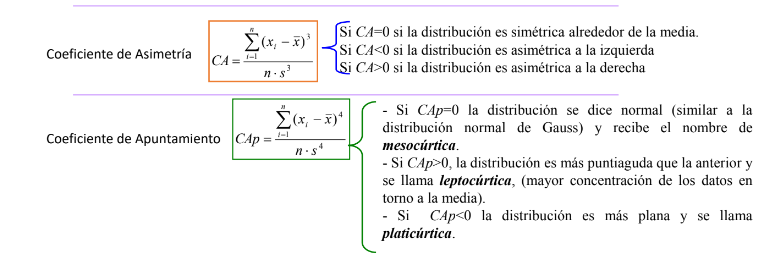

En base a esto se puede decir que el salario sigue una distribución asimétrica a la derecha y muy leptocúrtica, lo que puede visualizarse gráficamente en la siguiente imagen.

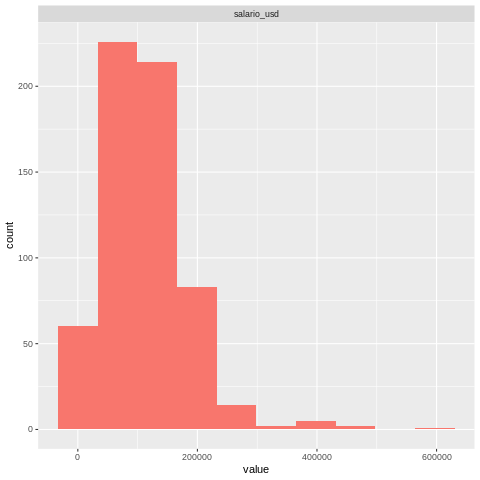

In [ ]:
%%R
plot_num(salarios)

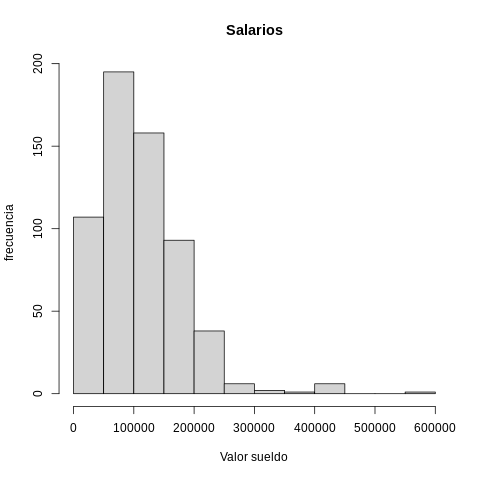

In [ ]:
%%R
hist(salarios$salario_usd, main = "Salarios", ylab = "frecuencia", xlab = "Valor sueldo")

Los salarios están distribuidos mayoritariamente entre 0 y 300000, con algunos mayores a está cantidad

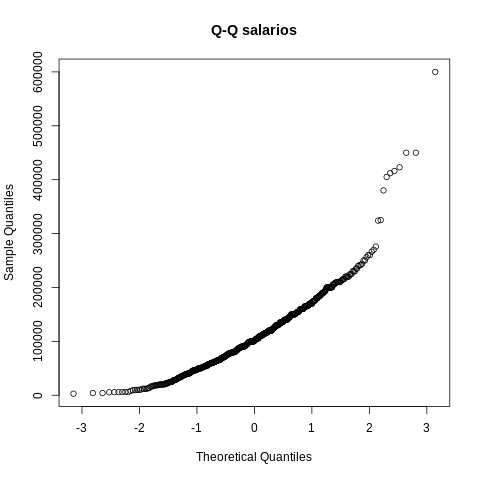

In [ ]:
%%R
qqnorm(salarios$salario_usd, main = "Q-Q salarios")

En la elección del test de normalidad para este caso lo más apropiado es utilizar el de Kolmogorov-Smirnov ya que se cuenta con una cantidad de muestras superior a 50.

In [ ]:
%%R
lillie.test(x = salarios$salario_usd)


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  salarios$salario_usd
D = 0.075327, p-value = 0.00000001004



El p-value es menor a 0.05 por lo que puede rechazarse la hipotesis nula y concluir que las distribuciones no son normales.

Sin embargo, se podría analizar más a fondo la variable salario para verificar si existen outliers que esten afectando a la distribución

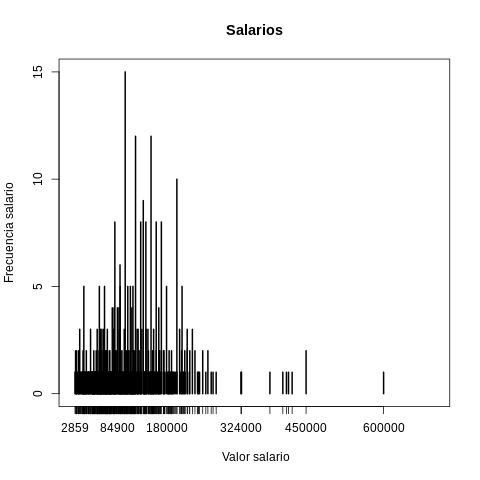

In [ ]:
%%R
plot(table(salarios$salario_usd),xlim=c(0,700000), main = "Salarios", ylab = "Frecuencia salario", xlab = " Valor salario")

En este gráfico se observa claramente que los valores de salario menores a 300000 podrían seguir una distribución normal, y los salarios mayores a ese monto parecen ser outliers. Lo que también puede verse haciendo un boxplot

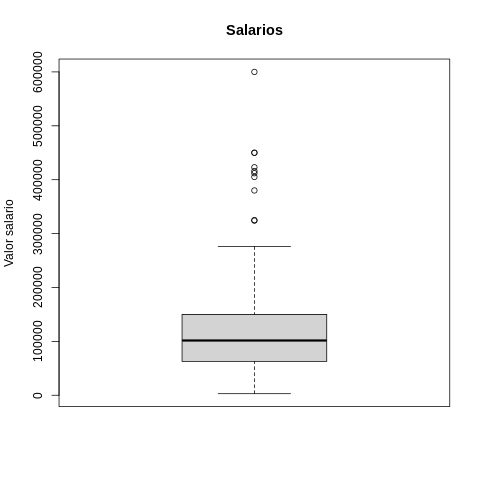

In [ ]:
%%R
boxplot(salarios$salario_usd, main = "Salarios", ylab = "Valor salario")

**Prueba de normalidad quitando salarios mayor iguales a 30000**

[1] "Cantidad de datos:  597"


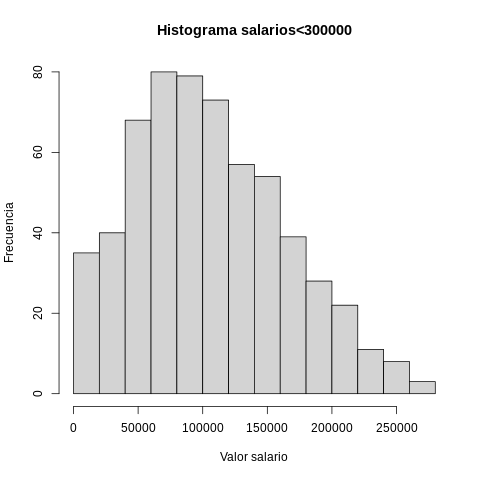

In [ ]:
%%R
salario_usd_filt <- filter(salarios,salario_usd<300000)$salario_usd
print(paste("Cantidad de datos: ",length(salario_usd_filt)))
hist(salario_usd_filt, main = "Histograma salarios<300000", xlab = "Valor salario", ylab = "Frecuencia")

In [ ]:
%%R
lillie.test(x = salario_usd_filt)


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  salario_usd_filt
D = 0.054583, p-value = 0.0002252



El p-value es sigue siendo menor a 0.05 pero la distribución comienza a acercarse a la forma de una distribución normal

Posteriormente cuando se realicen analisís bivariados y multivariados se podrá verificar si existe otra u otras variables que permitan separar los salarios y explicar estos valores atipicos

##Variables cualitativas

   var frequency percentage cumulative_perc
1 2022       318      52.39           52.39
2 2021       217      35.75           88.14
3 2020        72      11.86          100.00


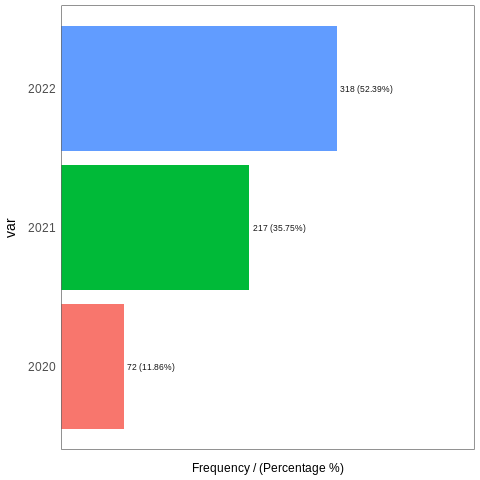

In [ ]:
%%R
freq(salarios$año_trabajado)

Observando los años de los datos, aproximadamente la mitad corresponden al 2022 y del resto una gran parte corresponde al 2021 mientras que el resto son del 2020.

  var frequency percentage cumulative_perc
1  SE       280      46.13           46.13
2  MI       213      35.09           81.22
3  EN        88      14.50           95.72
4  EX        26       4.28          100.00


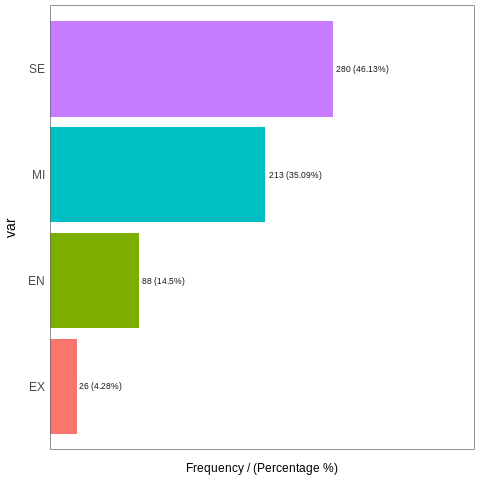

In [ ]:
%%R
freq(salarios$nivel_experiencia)

Para el caso de los distintos niveles de experiencia se observa que la mayor cantidad de trabajadores son de nivel Senior y un poco menos de nivel intermedio, mientras que hay pocos de nivel Junior y la menor cantidad es de nivel ejecutivo. 

  var frequency percentage cumulative_perc
1  FT       588      96.87           96.87
2  PT        10       1.65           98.52
3  CT         5       0.82           99.34
4  FL         4       0.66          100.00


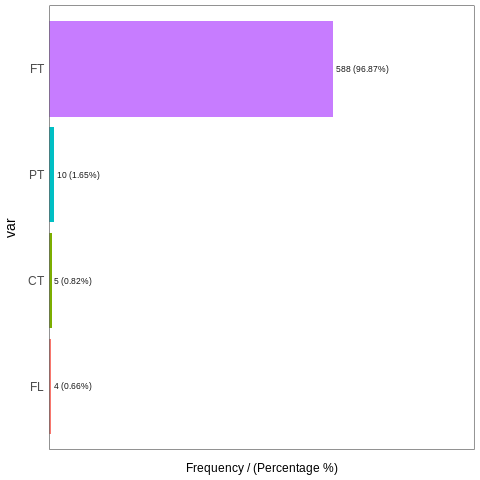

In [ ]:
%%R
freq(salarios$tipo_empleo)

Para el caso del tipo de empleo se ve que casi en su totalidad los trabajdores son full time, con muy pocos datos de los demas tipos. En este caso, para este dataset, la variable está muy desbalanceada, por lo que al utilizar está variable para analisís se debe tener cuidado al tener poca cantidad de muestras de algunos valores.

                                        var frequency percentage
1                            Data Scientist       143      23.56
2                             Data Engineer       132      21.75
3                              Data Analyst        97      15.98
4                 Machine Learning Engineer        41       6.75
5                        Research Scientist        16       2.64
6                      Data Science Manager        12       1.98
7                            Data Architect        11       1.81
8                         Big Data Engineer         8       1.32
9                Machine Learning Scientist         8       1.32
10                             AI Scientist         7       1.15
11                   Data Analytics Manager         7       1.15
12                  Data Science Consultant         7       1.15
13                 Director of Data Science         7       1.15
14                 Principal Data Scientist         7       1.15
15                       

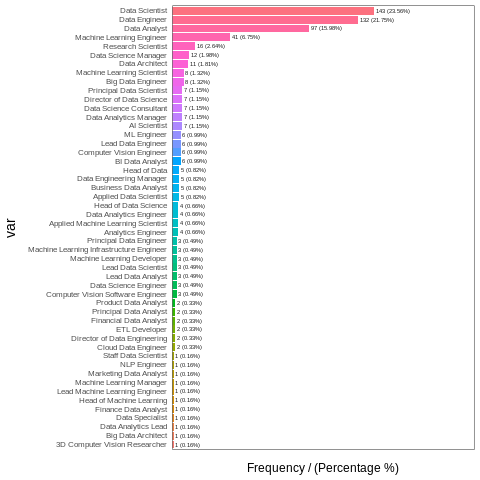

In [ ]:
%%R
freq(salarios$cargo)

En este caso se observa que aproximadamente el 70% de los trabajadores están comprendidos entre los cargos "Data Scientist", "Data Engineer", "Data Analyst", "Machine Learning Engineer" y "Research Scientist", mientrás que el 30% restante está dividido entre los demás cargos.

#Limpieza extra

Observando los valores de la variable se ve que hay cargos que son similares, podrían reemplazarse por nombres más generales, como "Cientifico", "Ingeniero", "Analista" y "Otro". Se crea una nueva variable que diga el cargo general del trabajador.

In [ ]:
%%R
cargo_cal= c(0,1)
for (i in 1:nrow(salarios)) {
    if(str_contains(salarios$cargo[i], "Scientist", ignore.case = TRUE))      cargo_cal[i] =  "Cientifico"
    else if(str_contains(salarios$cargo[i], "Engineer", ignore.case = TRUE))      cargo_cal[i] =  "Ingeniero"
    else if(str_contains(salarios$cargo[i], "Analyst", ignore.case = TRUE))      cargo_cal[i] =  "Analista"
    else cargo_cal[i] =  "Otro"
}
salarios$cargo_general <- cargo_cal
head(salarios[c("cargo","cargo_general")])

Para ver por que otros nombres se podrian agrupar vemos los que quedaron en el apartado "Otro"

In [ ]:
%%R
print(select(filter(salarios,cargo_general == "Otro"),cargo,cargo_general))

In [ ]:
%%R
cargo_cal= c(0,1)
for (i in 1:nrow(salarios)) {
    if(str_contains(salarios$cargo[i], "Scientist", ignore.case = TRUE))      cargo_cal[i] =  "Cientifico"
    else if(str_contains(salarios$cargo[i], "Engineer", ignore.case = TRUE))      cargo_cal[i] =  "Ingeniero"
    else if(str_contains(salarios$cargo[i], "Analyst", ignore.case = TRUE))      cargo_cal[i] =  "Analista"
    else if(str_contains(salarios$cargo[i], "Manager", ignore.case = TRUE))      cargo_cal[i] =  "Gerente"
    else if(str_contains(salarios$cargo[i], "Architect", ignore.case = TRUE))      cargo_cal[i] =  "Arquitecto"
    else if(str_contains(salarios$cargo[i], "Developer", ignore.case = TRUE))      cargo_cal[i] =  "Desarrollador"
    else cargo_cal[i] =  "Otro"
}
salarios$cargo_general <- cargo_cal

In [ ]:
%%R
print(select(filter(salarios,cargo_general == "Otro"),cargo,cargo_general))

In [ ]:
%%R
cargo_cal= c(0,1)
for (i in 1:nrow(salarios)) {
    if(str_contains(salarios$cargo[i], "Scientist", ignore.case = TRUE))      cargo_cal[i] =  "Cientifico"
    else if(str_contains(salarios$cargo[i], "Engineer", ignore.case = TRUE))      cargo_cal[i] =  "Ingeniero"
    else if(str_contains(salarios$cargo[i], "Analyst", ignore.case = TRUE))      cargo_cal[i] =  "Analista"
    else if(str_contains(salarios$cargo[i], "Manager", ignore.case = TRUE))      cargo_cal[i] =  "Gerente"
    else if(str_contains(salarios$cargo[i], "Architect", ignore.case = TRUE))      cargo_cal[i] =  "Arquitecto"
    else if(str_contains(salarios$cargo[i], "Developer", ignore.case = TRUE))      cargo_cal[i] =  "Desarrollador"
    else if(str_contains(salarios$cargo[i], "Consultant", ignore.case = TRUE))      cargo_cal[i] =  "Consultor"
    else if(str_contains(salarios$cargo[i], "Director", ignore.case = TRUE))      cargo_cal[i] =  "Jefe"
    else if(str_contains(salarios$cargo[i], "Head", ignore.case = TRUE))      cargo_cal[i] =  "Jefe"
    else if(str_contains(salarios$cargo[i], "Lead", ignore.case = TRUE))      cargo_cal[i] =  "Jefe"
    else cargo_cal[i] =  "Otro"
}
salarios$cargo_general <- cargo_cal

In [ ]:
%%R
print(select(filter(salarios,cargo_general == "Otro"),cargo,cargo_general))

Para estos casos particulares se decide colocar como científico al trabajador encargado como "Researcher" y como analista al "Specialist"

In [ ]:
%%R
salarios[salarios$cargo=="3D Computer Vision Researcher",]$cargo_general <- "Cientifico"
salarios[salarios$cargo=="Data Specialist",]$cargo_general <- "Analista"

In [ ]:
%%R
print(select(filter(salarios,cargo_general == "Otro"),cargo,cargo_general))

In [ ]:
%%R
salarios$cargo_general  <- as.factor(salarios$cargo_general)

Hecho esto se puede eliminar la columna de "cargo"

In [ ]:
%%R
salarios <- salarios[ , !names(salarios) %in% c("cargo")]

In [ ]:
%%R
str(salarios)

#Continuación Analisis univariado

##Continuación variables cualitativas

Finalizada está limpieza se visualiza está nueva variable

            var frequency percentage cumulative_perc
1     Ingeniero       230      37.89           37.89
2    Cientifico       195      32.13           70.02
3      Analista       120      19.77           89.79
4       Gerente        20       3.29           93.08
5          Jefe        18       2.97           96.05
6    Arquitecto        12       1.98           98.03
7     Consultor         7       1.15           99.18
8 Desarrollador         5       0.82          100.00


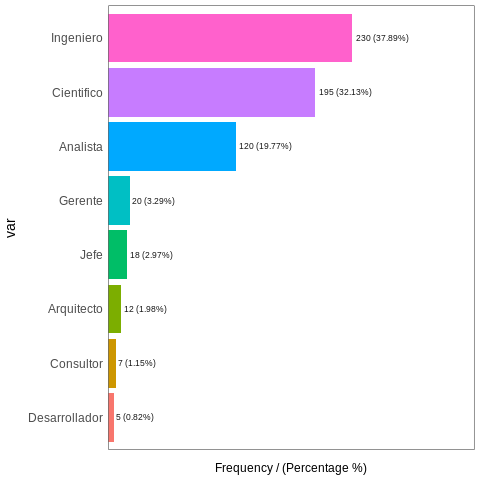

In [ ]:
%%R
freq(salarios$cargo_general)

Ahora las conclusiones que pueden extraerse es que la gran mayoría, casi el 90%, de los trabajadores tienen cargos como ingenieros, cientificos o analistas y el resto de los pocos están distribuidos en otros cargos como gerentes o jefes, etc

   var frequency percentage cumulative_perc
1  USD       398      65.57           65.57
2  EUR        95      15.65           81.22
3  GBP        44       7.25           88.47
4  INR        27       4.45           92.92
5  CAD        18       2.97           95.89
6  JPY         3       0.49           96.38
7  PLN         3       0.49           96.87
8  TRY         3       0.49           97.36
9  AUD         2       0.33           97.69
10 BRL         2       0.33           98.02
11 CNY         2       0.33           98.35
12 DKK         2       0.33           98.68
13 HUF         2       0.33           99.01
14 MXN         2       0.33           99.34
15 SGD         2       0.33           99.67
16 CHF         1       0.16           99.83
17 CLP         1       0.16          100.00


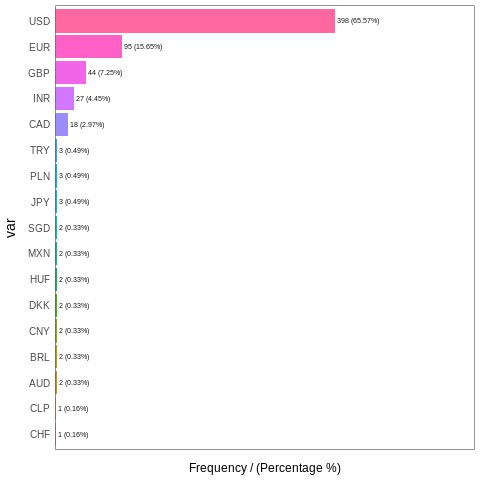

In [ ]:
%%R
freq(salarios$moneda_remunerada)

Se ve que la moneda predominante en las remuneraciones es en dolares, seguido por el euro, la libra, la rupia india y el peso canadiense, luego otras monedas en una cantidad muy pequeña

   var frequency percentage cumulative_perc
1   US       332      54.70           54.70
2   GB        44       7.25           61.95
3   IN        30       4.94           66.89
4   CA        29       4.78           71.67
5   DE        25       4.12           75.79
6   FR        18       2.97           78.76
7   ES        15       2.47           81.23
8   GR        13       2.14           83.37
9   JP         7       1.15           84.52
10  BR         6       0.99           85.51
11  PK         6       0.99           86.50
12  PT         6       0.99           87.49
13  NL         5       0.82           88.31
14  IT         4       0.66           88.97
15  PL         4       0.66           89.63
16  RU         4       0.66           90.29
17  AE         3       0.49           90.78
18  AT         3       0.49           91.27
19  AU         3       0.49           91.76
20  TR         3       0.49           92.25
21  VN         3       0.49           92.74
22  BE         2       0.33     

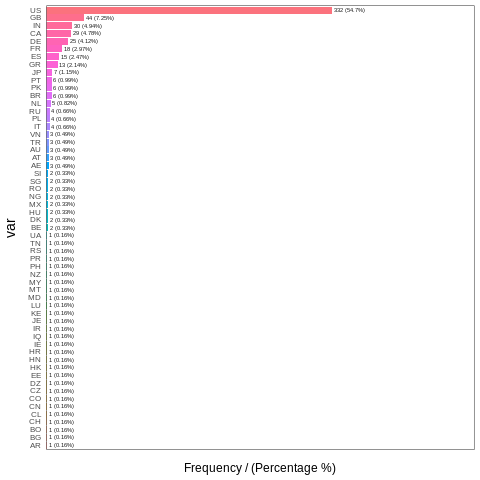

In [ ]:
%%R
freq(salarios$residencia_empleado)

Como cabe esperar, los porcentajes son similares a los de las monedas remuneradas, ya que por lo general una persona cobrará en la moneda del país donde vive. Sin embargo, hay mayor variedad ya que hay casos dónde los trabajadores prefieren cobrar en dólares por ser una moneda más fuerte.

  var frequency percentage cumulative_perc
1 100       381      62.77           62.77
2   0       127      20.92           83.69
3  50        99      16.31          100.00


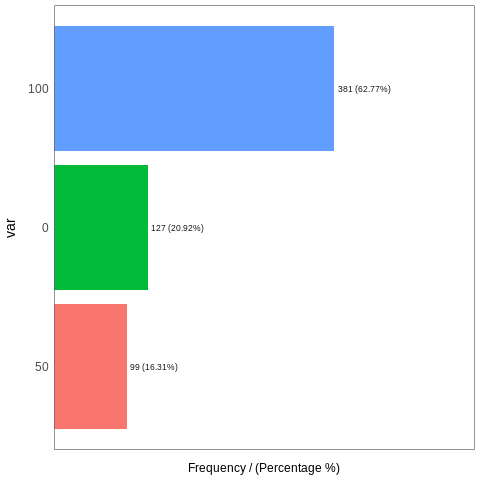

In [ ]:
%%R
freq(salarios$ratio_trabajo_remoto)

En el caso del ratio de trabajo remoto se puede observar que casi dos tercios de los trabajadores trabajan de manera totalmente remota, mientras que el porcentaje que lo hace de manera presencial o semi-remota ocupan casi un tercio y son similares entre ellos

   var frequency percentage cumulative_perc
1   US       355      58.48           58.48
2   GB        47       7.74           66.22
3   CA        30       4.94           71.16
4   DE        28       4.61           75.77
5   IN        24       3.95           79.72
6   FR        15       2.47           82.19
7   ES        14       2.31           84.50
8   GR        11       1.81           86.31
9   JP         6       0.99           87.30
10  AT         4       0.66           87.96
11  NL         4       0.66           88.62
12  PL         4       0.66           89.28
13  PT         4       0.66           89.94
14  AE         3       0.49           90.43
15  AU         3       0.49           90.92
16  BR         3       0.49           91.41
17  DK         3       0.49           91.90
18  LU         3       0.49           92.39
19  MX         3       0.49           92.88
20  PK         3       0.49           93.37
21  TR         3       0.49           93.86
22  BE         2       0.33     

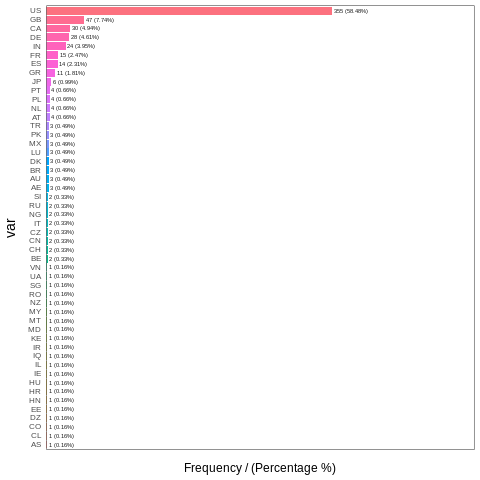

In [ ]:
%%R
freq(salarios$sede_empresa)

Nuevamente una variación similar a la de la residencia de los empleados

  var frequency percentage cumulative_perc
1   M       326      53.71           53.71
2   L       198      32.62           86.33
3   S        83      13.67          100.00


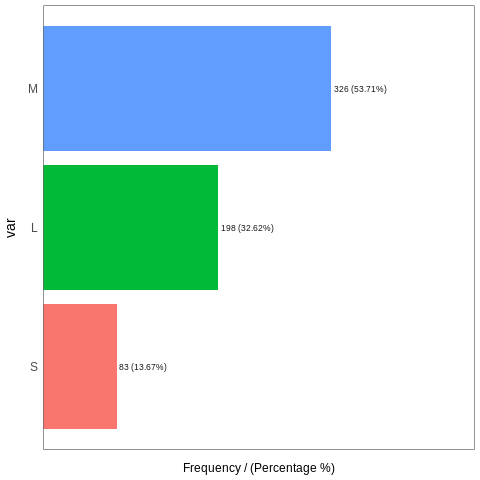

In [ ]:
%%R
freq(salarios$tamaño_empresa)

En cuanto al tamaño de la empresa la mayoria de los trabajadores pertenecen a una empresa mediana, un tercio a empresa grandes y unos pocos a empresas pequeñas.

#Analisis bivariado

##Relaciones cuantitativas - cuantitativas

Ya que sólo hay una variable cuantativa, el salario, no pueden analizarse relaciones entre variables cuantitativas.

##Relaciones cuantitativas - cualitativas

En este caso se analiza a la variable salario con respecto a cada una de las otras variables para encontrar posibles efectos de las mismas en el salario.

In [ ]:
%%R
str(salarios)

'data.frame':	607 obs. of  10 variables:
 $ año_trabajado       : Factor w/ 3 levels "2020","2021",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ nivel_experiencia   : Factor w/ 4 levels "EN","EX","MI",..: 3 4 4 3 4 1 4 3 3 4 ...
 $ tipo_empleo         : Factor w/ 4 levels "CT","FL","FT",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ moneda_remunerada   : Factor w/ 17 levels "AUD","BRL","CAD",..: 8 17 9 17 17 17 17 10 17 17 ...
 $ salario_usd         : int  79833 260000 109024 20000 150000 72000 190000 35735 135000 125000 ...
 $ residencia_empleado : Factor w/ 57 levels "AE","AR","AT",..: 15 33 21 24 56 56 56 26 56 42 ...
 $ ratio_trabajo_remoto: Factor w/ 3 levels "0","50","100": 1 1 2 1 2 3 3 2 3 2 ...
 $ sede_empresa        : Factor w/ 50 levels "AE","AS","AT",..: 13 30 19 21 49 49 49 23 49 39 ...
 $ tamaño_empresa      : Factor w/ 3 levels "L","M","S": 1 3 2 3 1 1 3 1 1 3 ...
 $ cargo_general       : Factor w/ 8 levels "Analista","Arquitecto",..: 3 3 7 1 7 1 3 3 1 7 ...


In [ ]:
%%R
efectos <- list()

###Salario - Año

**Analisis gráfico**

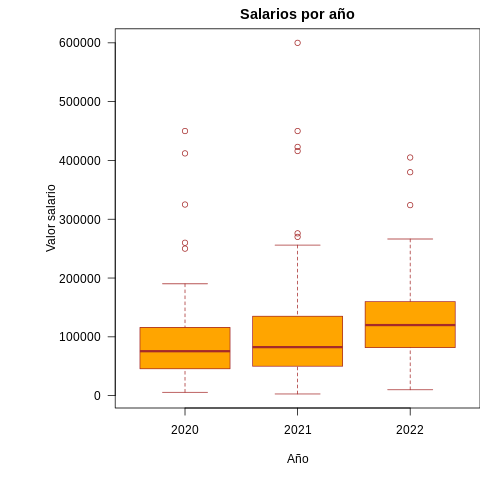

In [ ]:
%%R
par(mgp=c(3,1,0))
par(mar=c(5,8,2,0))
boxplot(salario_usd ~ año_trabajado, data =salarios,
                      main = "Salarios por año",
                      xlab = "Año",
                      ylab = "Valor salario\n",
                      col = "orange",
                      border = "brown",
                      horizontal = FALSE,
                      notch = FALSE,
                      las = 1)

Gráficamente pareciese que los salarios de 2020 y 2021 son similares pero que ambos difieren de los pagados en 2022.

**Tests para verificar normalidad**

In [ ]:
%%R
Test.SW=function(x){shapiro.test(x)$p.value}
aggregate(salario_usd ~ año_trabajado, data=salarios,FUN=Test.SW)

  año_trabajado             salario_usd
1          2020 0.000000003466246334777
2          2021 0.000000000000007066856
3          2022 0.000000223471294483522


En los tres casos el p-value es menor a 0.05, por lo que ningun grupo sigue una distribución normal. Debido a esto se utiliza para la comparación al test de Kruskal-Wallis

In [ ]:
%%R
kruskal.test(salario_usd ~ año_trabajado, data=salarios)


	Kruskal-Wallis rank sum test

data:  salario_usd by año_trabajado
Kruskal-Wallis chi-squared = 46.727, df = 2, p-value = 0.00000000007133



Como p-value<0.05 se puede rechazar la hipótesis nula y decir que existe diferencia entre los grupos, es decir que existe diferencia entre los salarios dependiendo del año trabajado. Para explorar estas diferencias más en detalle se lleva a cabo un analisis de efecto, y tests post-hoc para cuantizar diferencias particulares entre 2 grupos.

**Analisis del efecto de la variable**

In [ ]:
%%R
año_trabajado <- epsilonSquared(x = salarios$salario_usd, g = salarios$año_trabajado)
efectos$año_trabajado <- año_trabajado
print(efectos$año_trabajado)

epsilon.squared 
         0.0771 


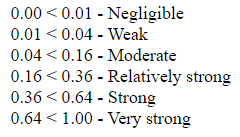

El efecto de la variable año trabajado parece ser moderado en el salario basado en el valor de epsilon cuadrado.

**Post-hoc**

In [ ]:
%%R
pairwise.wilcox.test(salarios$salario_usd, salarios$año_trabajado)


	Pairwise comparisons using Wilcoxon rank sum test with continuity correction 

data:  salarios$salario_usd and salarios$año_trabajado 

     2020        2021       
2021 0.46        -          
2022 0.000001126 0.000000013

P value adjustment method: holm 


In [ ]:
%%R
dunnTest(salario_usd ~ año_trabajado, data=salarios)

R[write to console]: Dunn (1964) Kruskal-Wallis multiple comparison

R[write to console]:   p-values adjusted with the Holm method.




   Comparison          Z           P.unadj             P.adj
1 2020 - 2021 -0.8743599 0.381922272144545 0.381922272144545
2 2020 - 2022 -4.9058133 0.000000930409757 0.000001860819515
3 2021 - 2022 -5.9210545 0.000000003198838 0.000000009596513


En conclusión, no existe evidencia para decir que los salarios de 2020 y 2021 sean diferentes entre si pero si se diferencian ambos con respecto a los salarios de 2022, lo cual indica que los salarios pagados en 2022 son más altos. Esto puede explicarse, tal vez, por el contexto de pandemia que se vivió en 2020/2021, donde su efecto ya fue muy leve durante 2022.

###Salario - Nivel de experiencia

**Analisis gráfico**

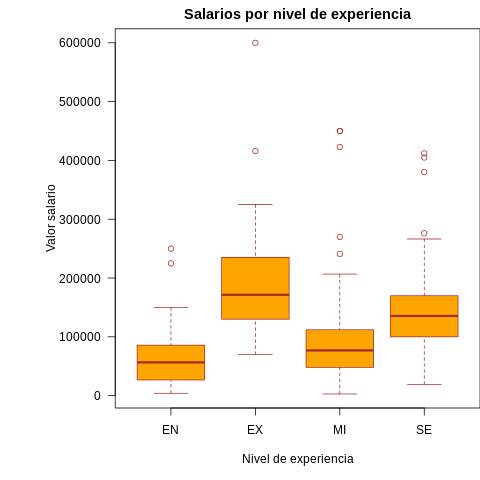

In [ ]:
%%R
par(mgp=c(3,1,0))
par(mar=c(5,8,2,0))
boxplot(salario_usd ~ nivel_experiencia, data =salarios,
                      main = "Salarios por nivel de experiencia",
                      xlab = "Nivel de experiencia",
                      ylab = "Valor salario\n",
                      col = "orange",
                      border = "brown",
                      horizontal = FALSE,
                      notch = FALSE,
                      las = 1)

Gráficamente se puede observar que parecieran ser similares los salarios entre trabajadores de experiencia junior e intermedio pero que según los otros niveles de experiencia el salario difiere significativamente.

**Tests para verificar normalidad**

In [ ]:
%%R
Test.SW=function(x){shapiro.test(x)$p.value}
aggregate(salario_usd ~ nivel_experiencia, data=salarios,FUN=Test.SW)

  nivel_experiencia              salario_usd
1                EN 0.0000018308551986315592
2                EX 0.0008209138084586774372
3                MI 0.0000000000000006142584
4                SE 0.0000000285047075572022


En los cuatro casos el p-value es menor a 0.05, por lo que ningun grupo sigue una distribución normal. Debido a esto se utiliza para la comparación al test de Kruskal-Wallis

In [ ]:
%%R
kruskal.test(salario_usd ~ nivel_experiencia, data=salarios)


	Kruskal-Wallis rank sum test

data:  salario_usd by nivel_experiencia
Kruskal-Wallis chi-squared = 190.11, df = 3, p-value <
0.00000000000000022



Como p-value<0.05 se puede rechazar la hipótesis nula y decir que existe diferencia entre los grupos, es decir que existe diferencia entre los salarios dependiendo del nivel de experiencia. Para explorar estas diferencias más en detalle se lleva a cabo un analisis de efecto, y tests post-hoc para cuantizar diferencias particulares entre 2 grupos.

**Analisis del efecto de la variable**

In [ ]:
%%R
nivel_experiencia <- epsilonSquared(x = salarios$salario_usd, g = salarios$nivel_experiencia)
efectos$nivel_experiencia <- nivel_experiencia
print(efectos$nivel_experiencia)

epsilon.squared 
          0.314 


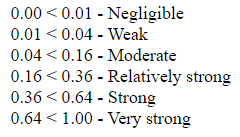

El efecto de la variable nivel de experiencia parece ser relativamente fuerte en el salario basado en el valor de epsilon cuadrado.

**Post-hoc**

In [ ]:
%%R
pairwise.wilcox.test(salarios$salario_usd, salarios$nivel_experiencia)


	Pairwise comparisons using Wilcoxon rank sum test with continuity correction 

data:  salarios$salario_usd and salarios$nivel_experiencia 

   EN                   EX            MI                  
EX 0.00000000015        -             -                   
MI 0.00025              0.00000000606 -                   
SE < 0.0000000000000002 0.00426       < 0.0000000000000002

P value adjustment method: holm 


In [ ]:
%%R
dunnTest(salario_usd ~ nivel_experiencia, data=salarios)

R[write to console]: Dunn (1964) Kruskal-Wallis multiple comparison

R[write to console]:   p-values adjusted with the Holm method.




  Comparison          Z                             P.unadj
1    EN - EX  -7.875332 0.000000000000003398403770568679841
2    EN - MI  -3.268925 0.001079568447813602539986366224412
3    EX - MI   6.467913 0.000000000099365629849636025253390
4    EN - SE -10.891661 0.000000000000000000000000001263156
5    EX - SE   2.081931 0.037348795696920206177438217309827
6    MI - SE -10.083869 0.000000000000000000000006511068235
                                P.adj
1 0.000000000000013593615082274719363
2 0.002159136895627205079972732448823
3 0.000000000298096889548908049910775
4 0.000000000000000000000000007578934
5 0.037348795696920206177438217309827
6 0.000000000000000000000032555341173


En conclusión, se puede decir que hay diferencia significativa entre todos los niveles de experiencia. Lo que indica también por el nivel de efecto que es una variable importante en la determinación del salario. Los trabajadores de nivel ejecutivo reciben mejores salarios, luego los trabajadores senior, seguidos por los intermedios y finalmente los junior

###Salario - Tipo de empleo

**Analisis gráfico**

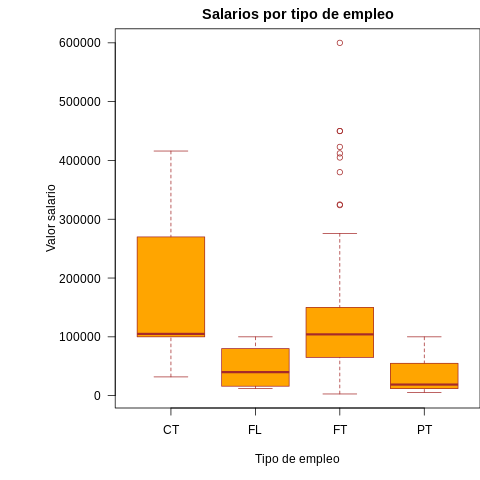

In [ ]:
%%R
par(mgp=c(3,1,0))
par(mar=c(5,8,2,0))
boxplot(salario_usd ~ tipo_empleo, data =salarios,
                      main = "Salarios por tipo de empleo",
                      xlab = "Tipo de empleo",
                      ylab = "Valor salario\n",
                      col = "orange",
                      border = "brown",
                      horizontal = FALSE,
                      notch = FALSE,
                      las = 1)

Gráficamente pareciese que la distribución de los salarios según tipo de empleo son diferentes.

**Tests para verificar normalidad**

In [ ]:
%%R
Test.SW=function(x){shapiro.test(x)$p.value}
aggregate(salario_usd ~ tipo_empleo, data=salarios,FUN=Test.SW)

  tipo_empleo                 salario_usd
1          CT 0.4055573107282854916633141
2          FL 0.5067262176446606369850656
3          FT 0.0000000000000000004347558
4          PT 0.0225444981490951455727068


En el caso del grupo contract-time y freelancers no existe evidencia para rechazar al test de normalidad pero no es el caso para los grupos full-time y part-time, por estos no verificar normalidad se procede con el test de Kruskal-Wallis para la comparación.

In [ ]:
%%R
kruskal.test(salario_usd ~ tipo_empleo, data=salarios)


	Kruskal-Wallis rank sum test

data:  salario_usd by tipo_empleo
Kruskal-Wallis chi-squared = 22.419, df = 3, p-value = 0.00005337



Como p-value<0.05 se puede rechazar la hipótesis nula y decir que existe diferencia entre los grupos, es decir que existe diferencia entre los salarios dependiendo del tipo de empleo. Para explorar estas diferencias más en detalle se lleva a cabo un analisis de efecto, y tests post-hoc para cuantizar diferencias particulares entre 2 grupos.

**Analisis del efecto de la variable**

In [ ]:
%%R
tipo_empleo <- epsilonSquared(x = salarios$salario_usd, g = salarios$tipo_empleo)
efectos$tipo_empleo <- tipo_empleo
print(efectos$tipo_empleo)

epsilon.squared 
          0.037 


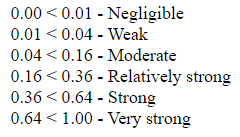

El efecto de la variable tipo de empleo parece ser débil en el salario basado en el valor de epsilon cuadrado.

**Post-hoc**

In [ ]:
%%R
pairwise.wilcox.test(salarios$salario_usd, salarios$tipo_empleo)


	Pairwise comparisons using Wilcoxon rank sum test with continuity correction 

data:  salarios$salario_usd and salarios$tipo_empleo 

   CT      FL      FT     
FL 0.25530 -       -      
FT 0.81048 0.13138 -      
PT 0.04989 0.81048 0.00019

P value adjustment method: holm 


In [ ]:
%%R
dunnTest(salario_usd ~ tipo_empleo, data=salarios)

R[write to console]: Dunn (1964) Kruskal-Wallis multiple comparison

R[write to console]:   p-values adjusted with the Holm method.




  Comparison          Z       P.unadj        P.adj
1    CT - FL  2.1413096 0.03224908346 0.1289963338
2    CT - FT  0.8236626 0.41013128776 0.8202625755
3    FL - FT -2.1258179 0.03351842086 0.1005552626
4    CT - PT  3.0967838 0.00195632484 0.0097816242
5    FL - PT  0.4390479 0.66062683015 0.6606268302
6    FT - PT  4.1587952 0.00003199306 0.0001919583


En conclusión, existe evidencia para afirmar que los salarios entre trabajadores de tipo part-time con los contract-time y full-time, pero no para el caso de las demás comparaciones. Esto indicaría que está variable no es significativa para el caso de los salarios, también pueden deberse los resultados a la baja representación de trabajadores de tipo de empleo diferente al full-time como se vió previamente.

###Salario - Moneda remunerada

Para este caso se analizarán solo monedas las cuales haya más de 3 observaciones para simplificar el analisis y evitar sacar conclusiones de un grupo del cuál se posee pocas observaciones.

In [ ]:
%%R
salarios_mon_filt <- salarios[with(salarios, moneda_remunerada %in% names(which(table(moneda_remunerada)>3))),c("moneda_remunerada","salario_usd") ]
str(salarios_mon_filt)

'data.frame':	582 obs. of  2 variables:
 $ moneda_remunerada: Factor w/ 17 levels "AUD","BRL","CAD",..: 8 17 9 17 17 17 17 17 17 8 ...
 $ salario_usd      : int  79833 260000 109024 20000 150000 72000 190000 135000 125000 51321 ...


In [ ]:
%%R
salarios_mon_filt$moneda_remunerada <- droplevels(salarios_mon_filt$moneda_remunerada)
table(salarios_mon_filt$moneda_remunerada)


CAD EUR GBP INR USD 
 18  95  44  27 398 


**Analisis gráfico**

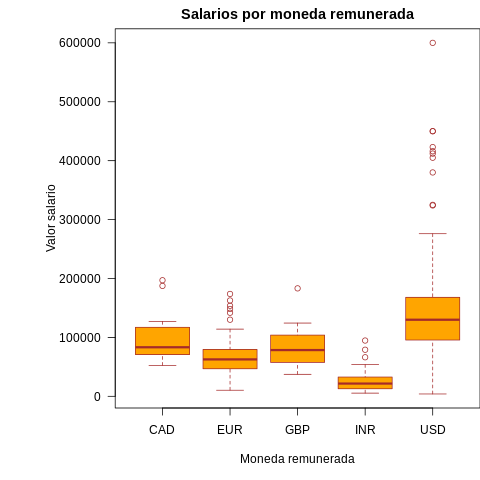

In [ ]:
%%R
par(mgp=c(3,1,0))
par(mar=c(5,8,2,0))
boxplot(salario_usd ~ moneda_remunerada, data =salarios_mon_filt,
                      main = "Salarios por moneda remunerada",
                      xlab = "Moneda remunerada",
                      ylab = "Valor salario\n",
                      col = "orange",
                      border = "brown",
                      horizontal = FALSE,
                      notch = FALSE,
                      las = 1)

Gráficamente es díficil establecer diferencias o no, pareciese que los salarios pagados en rupias indias son considerablemente más bajos al resto y los pagados en dólares mayores

**Tests para verificar normalidad**

In [ ]:
%%R
Test.SW=function(x){shapiro.test(x)$p.value}
aggregate(salario_usd ~ moneda_remunerada, data=salarios_mon_filt,FUN=Test.SW)

  moneda_remunerada             salario_usd
1               CAD 0.006781012924630539992
2               EUR 0.000014095285774817081
3               GBP 0.019629104955165156687
4               INR 0.000648779581026481746
5               USD 0.000000000000000361875


En los cinco casos el p-value es menor a 0.05, por lo que ningun grupo sigue una distribución normal. Debido a esto se utiliza para la comparación al test de Kruskal-Wallis

In [ ]:
%%R
kruskal.test(salario_usd ~ moneda_remunerada, data=salarios_mon_filt)


	Kruskal-Wallis rank sum test

data:  salario_usd by moneda_remunerada
Kruskal-Wallis chi-squared = 192.26, df = 4, p-value <
0.00000000000000022



Como p-value<0.05 se puede rechazar la hipótesis nula y decir que existe diferencia entre los grupos, es decir que existe diferencia entre los salarios dependiendo de la moneda remunerada. Para explorar estas diferencias más en detalle se lleva a cabo un analisis de efecto, y tests post-hoc para cuantizar diferencias particulares entre 2 grupos.

**Analisis del efecto de la variable**

In [ ]:
%%R
moneda_remunerada <- epsilonSquared(x = salarios_mon_filt$salario_usd, g = salarios_mon_filt$moneda_remunerada)
efectos$moneda_remunerada <- moneda_remunerada
print(efectos$moneda_remunerada)

epsilon.squared 
          0.331 


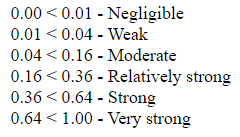

El efecto de la variable moneda remunerada parece ser relativamente fuerte en el salario basado en el valor de epsilon cuadrado.

**Post-hoc**

In [ ]:
%%R
pairwise.wilcox.test(salarios_mon_filt$salario_usd, salarios_mon_filt$moneda_remunerada, exact = FALSE)


	Pairwise comparisons using Wilcoxon rank sum test with continuity correction 

data:  salarios_mon_filt$salario_usd and salarios_mon_filt$moneda_remunerada 

    CAD               EUR                  GBP               INR              
EUR 0.0019            -                    -                 -                
GBP 0.1796            0.0036               -                 -                
INR 0.000001829072920 0.000000064882055    0.000000011867922 -                
USD 0.0042            < 0.0000000000000002 0.000000002279801 0.000000000000031

P value adjustment method: holm 


In [ ]:
%%R
dunnTest(salario_usd ~ moneda_remunerada, data=salarios_mon_filt)

R[write to console]: Dunn (1964) Kruskal-Wallis multiple comparison

R[write to console]:   p-values adjusted with the Holm method.




   Comparison           Z                            P.unadj
1   CAD - EUR   2.2927950 0.02185981269476365562720587831791
2   CAD - GBP   0.9758321 0.32914767068836930929975892468065
3   EUR - GBP  -1.7348854 0.08276110792912164115797679642128
4   CAD - INR   3.8697841 0.00010893178923421430951811589294
5   EUR - INR   2.6967868 0.00700120800180028136222576407022
6   GBP - INR   3.6999169 0.00021567010166181541357816042748
7   CAD - USD  -2.6104728 0.00904171504581641714837214607314
8   EUR - USD -10.6705614 0.00000000000000000000000001397792
9   GBP - USD  -5.6781021 0.00000001361973895068119732913840
10  INR - USD  -9.0842490 0.00000000000000000010441700337777
                               P.adj
1  0.0655794380842909668816176349537
2  0.3291476706883693092997589246806
3  0.1655222158582432823159535928426
4  0.0007625225246395002072843927188
5  0.0350060400090014059437670823627
6  0.0012940206099708924814689625649
7  0.0361668601832656685934885842926
8  0.0000000000000000000000001397

En conclusión, en ambos test se ve que los salarios remunerados en rupia india y en dólar son diferentes significativamente con los demás, lo que indica que los salarios pagados en rupia india son menores y los pagados en dolares mayores. También se puede decir que no existe evidencia para decir que los salarios remunerados en dolar canadiense y libras son diferentes. Finalmente, según los valores obtenidos en el test de dunnet, en los salarios remunerados en euros comparados con los remunerados en dolar canadiense y libras no existe evidencia para decir que son diferentes, sin emargo, el test de Kruskal-Wallis dice que los salarios en euros son diferentes a los remunerados en dolar canadiense y libras.

###Salario - Residencia del empleado

Para este caso se analizarán solo paises los cuales haya más de 5 observaciones para simplificar el analisis y evitar sacar conclusiones de un grupo del cuál se posee pocas observaciones.

In [ ]:
%%R
salarios_res_filt <- salarios[with(salarios, residencia_empleado %in% names(which(table(residencia_empleado)>5))),c("residencia_empleado","salario_usd") ]
str(salarios_res_filt)

'data.frame':	531 obs. of  2 variables:
 $ residencia_empleado: Factor w/ 57 levels "AE","AR","AT",..: 15 33 21 56 56 56 56 20 28 20 ...
 $ salario_usd        : int  79833 260000 109024 150000 72000 190000 135000 51321 40481 39916 ...


In [ ]:
%%R
salarios_res_filt$residencia_empleado <- droplevels(salarios_res_filt$residencia_empleado)
table(salarios_res_filt$residencia_empleado)


 BR  CA  DE  ES  FR  GB  GR  IN  JP  PK  PT  US 
  6  29  25  15  18  44  13  30   7   6   6 332 


**Analisis gráfico**

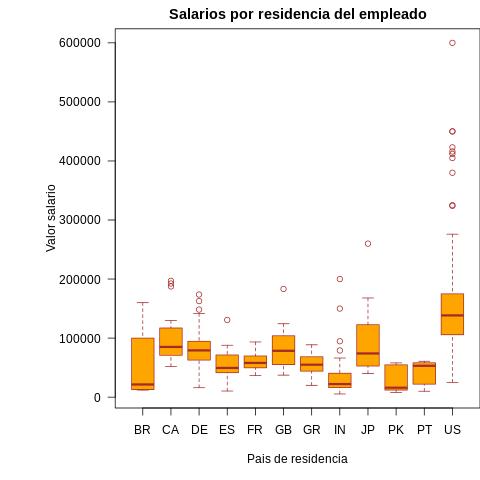

In [ ]:
%%R
par(mgp=c(3,1,0))
par(mar=c(5,8,2,0))
boxplot(salario_usd ~ residencia_empleado, data =salarios_res_filt,
                      main = "Salarios por residencia del empleado",
                      xlab = "Pais de residencia",
                      ylab = "Valor salario\n",
                      col = "orange",
                      border = "brown",
                      horizontal = FALSE,
                      notch = FALSE,
                      las = 1)

Gráficamente se observan grandes diferencias entre las distintas cajas, con claramente mayor a los salarios de trabajadors de Estados Unidos

**Tests para verificar normalidad**

In [ ]:
%%R
Test.SW=function(x){shapiro.test(x)$p.value}
aggregate(salario_usd ~ residencia_empleado, data=salarios_res_filt,FUN=Test.SW)

   residencia_empleado                salario_usd
1                   BR 0.025625815832060680476978
2                   CA 0.000521149066049132682517
3                   DE 0.072540941011642642854973
4                   ES 0.249855274717237230142075
5                   FR 0.578580556258734168828539
6                   GB 0.016382286608611584116657
7                   GR 0.892075818626898775498546
8                   IN 0.000000777060599965964685
9                   JP 0.034781669539686956016400
10                  PK 0.036194344366947239777232
11                  PT 0.082494856221347404034994
12                  US 0.000000000000000003274062


Se observa que múltiples grupos no siguen una distribución normal por tener p-values menores a 0,05. Debido a esto se utiliza para la comparación al test de Kruskal-Wallis

In [ ]:
%%R
kruskal.test(salario_usd ~ residencia_empleado, data=salarios_res_filt)


	Kruskal-Wallis rank sum test

data:  salario_usd by residencia_empleado
Kruskal-Wallis chi-squared = 246.32, df = 11, p-value <
0.00000000000000022



Como p-value<0.05 se puede rechazar la hipótesis nula y decir que existe diferencia entre los grupos, es decir que existe diferencia entre los salarios dependiendo del pais de residencia del trabajador. Para explorar estas diferencias más en detalle se lleva a cabo un analisis de efecto, y tests post-hoc para cuantizar diferencias particulares entre 2 grupos.

**Analisis del efecto de la variable**

In [ ]:
%%R
residencia_empleado <- epsilonSquared(x = salarios_res_filt$salario_usd, g = salarios_res_filt$residencia_empleado)
efectos$residencia_empleado <- residencia_empleado
print(efectos$residencia_empleado)

epsilon.squared 
          0.465 


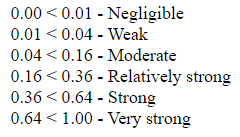

El efecto de la variable residencia del empleado parece ser fuerte en el salario basado en el valor de epsilon cuadrado.

**Post-hoc**

In [ ]:
%%R
pairwise.wilcox.test(salarios_res_filt$salario_usd, salarios_res_filt$residencia_empleado)


	Pairwise comparisons using Wilcoxon rank sum test with continuity correction 

data:  salarios_res_filt$salario_usd and salarios_res_filt$residencia_empleado 

   BR      CA                DE                ES               
CA 1.00000 -                 -                 -                
DE 1.00000 1.00000           -                 -                
ES 1.00000 0.02581           0.36524           -                
FR 1.00000 0.00384           0.28053           1.00000          
GB 1.00000 1.00000           1.00000           0.29238          
GR 1.00000 0.02237           0.44267           1.00000          
IN 1.00000 0.000013213675649 0.00071           0.11556          
JP 1.00000 1.00000           1.00000           1.00000          
PK 1.00000 0.01579           0.04224           1.00000          
PT 1.00000 0.02165           0.16922           1.00000          
US 0.12059 0.000018086168691 0.000003012403251 0.000000334889864
   FR                GB                GR                I

Como los valores son bastantes se seleccionan las combinaciones que hayan presentado un p-value menor a 0.05 para encontrar las que son significativamente diferentes

In [ ]:
%%R
p_values <- pairwise.wilcox.test(salarios_res_filt$salario_usd, salarios_res_filt$residencia_empleado)[[3]]
indices <- which(p_values<0.05)
indices1 <- dimnames(p_values)[[1]][(indices-1)%%11+1]
indices2 <- dimnames(p_values)[[2]][ceiling(indices/11)]
print(sort(paste(indices1," - ",indices2)))
sort(table(c(indices1,indices2)))

 [1] "ES  -  CA" "FR  -  CA" "GR  -  CA" "IN  -  CA" "IN  -  DE" "IN  -  FR"
 [7] "IN  -  GB" "PK  -  CA" "PK  -  DE" "PT  -  CA" "US  -  CA" "US  -  DE"
[13] "US  -  ES" "US  -  FR" "US  -  GB" "US  -  GR" "US  -  IN" "US  -  PK"
[19] "US  -  PT"

ES GB GR PT DE FR PK IN CA US 
 2  2  2  2  3  3  3  5  7  9 


No se detectaron diferencias entre trabajadores brasileños y japoneses, esto puede deberse a la gran variación que existe entre los salarios, lo que puede visualizarse por la gran amplitud de las cajas en el gráfico.
Si nos concentramos en los 10 paises restantes:

Se observa que salarios de trabajadores de Estados unidos poseen diferencias significativas con todos los demás, se puede decir que sus salarios son los más altos. 

Los salarios de canadadienses fueron diferentes significativamente con casi todos los demás paises excepto Dinamarca y Gran Bretaña, esto indica que los salarios de canadienses son también muy altos pero inferiores a los de estadounidenses.

Los salarios de Indios parecen diferenciarse significativamente con los de los 4 paises antes mencionados y Francia, lo que indica que son bastante inferiores.
Para el caso de salarios de Pakistanies presentan diferencias significativas con los de estadounidenses, canadienses y daneses, indicando que son bastante bajos pero no presentan diferencias con los de indios.

El resto de salarios, franceses, daneses, portugeses, griegos, británicos y españoles, de manera general presentan diferencias con alguno de los paises fuera de su continente.

Como conclusión general, se observa que los sueldos de trabajadores de paises de America del Norte suelen ser altos, los de trabajadores de Europa intermedios y los de paises asiaticos bajos.






In [ ]:
%%R
filter(dunnTest(salario_usd ~ residencia_empleado, data=salarios_res_filt)[[2]],P.unadj<0.05)

   Comparison         Z                       P.unadj
1     CA - ES  2.296471 0.021648977306948542775888455
2     CA - FR  2.428013 0.015181787974082894612792849
3     CA - GR  2.310130 0.020880938029843754133452194
4     CA - IN  3.689810 0.000224421362626666363870864
5     DE - IN  2.853094 0.004329585941826881619054479
6     GB - IN  2.875288 0.004036589794579246298633635
7     IN - JP -2.203620 0.027551074599502085177293864
8     CA - PK  2.531924 0.011343842657475249405263362
9     DE - PK  2.083779 0.037180230829221054544841962
10    GB - PK  1.965704 0.049332828113126475644278912
11    JP - PK  1.976545 0.048093116021980901464427660
12    CA - PT  2.144389 0.032001709791532308158057418
13    BR - US -3.527133 0.000420085213217459097021639
14    CA - US -4.368125 0.000012531774982197301193622
15    DE - US -4.986110 0.000000616071377940315894119
16    ES - US -5.971175 0.000000002355508897184648110
17    FR - US -6.505520 0.000000000077425226237407280
18    GB - US -7.017945 0.00

In [ ]:
%%R
filter(dunnTest(salario_usd ~ residencia_empleado, data=salarios_res_filt)[[2]],P.adj<0.05)

   Comparison         Z                       P.unadj
1     CA - IN  3.689810 0.000224421362626666363870864
2     BR - US -3.527133 0.000420085213217459097021639
3     CA - US -4.368125 0.000012531774982197301193622
4     DE - US -4.986110 0.000000616071377940315894119
5     ES - US -5.971175 0.000000002355508897184648110
6     FR - US -6.505520 0.000000000077425226237407280
7     GB - US -7.017945 0.000000000002251547963190372
8     GR - US -5.718886 0.000000010722464765677703117
9     IN - US -9.476836 0.000000000000000000002621109
10    PK - US -4.810113 0.000001508451176471671741441
11    PT - US -4.388167 0.000011431007249526506201753
                         P.adj
1  0.0127920176697199836080010
2  0.0235247719401777098668926
3  0.0007268429489674434760063
4  0.0000375803540543592721882
5  0.0000001483970605226328359
6  0.0000000049552144791940659
7  0.0000000001463506176073742
8  0.0000006647928154720176396
9  0.0000000000000000001729932
10 0.0000905070705883003070276
11 0.000674

Se observan resultados similares a los obtenidos previamente

###Salario - Ratio de trabajo remoto

**Analisis gráfico**

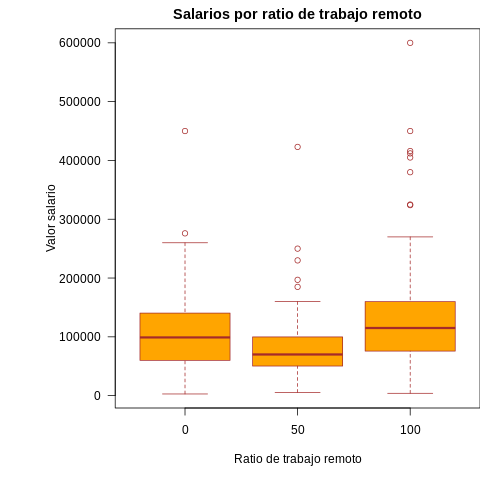

In [ ]:
%%R
par(mgp=c(3,1,0))
par(mar=c(5,8,2,0))
boxplot(salario_usd ~ ratio_trabajo_remoto, data =salarios,
                      main = "Salarios por ratio de trabajo remoto",
                      xlab = "Ratio de trabajo remoto",
                      ylab = "Valor salario\n",
                      col = "orange",
                      border = "brown",
                      horizontal = FALSE,
                      notch = FALSE,
                      las = 1)

Gráficamente pareciese existir diferencia entre los salarios de trabajadores que realicen su trabajo de manera semi-remota con respecto a las otras modalidades que parecen similares.

**Tests para verificar normalidad**

In [ ]:
%%R
Test.SW=function(x){shapiro.test(x)$p.value}
aggregate(salario_usd ~ ratio_trabajo_remoto, data=salarios,FUN=Test.SW)

  ratio_trabajo_remoto             salario_usd
1                    0 0.000002033716757316832
2                   50 0.000000000252505985509
3                  100 0.000000000000003914881


Ninguno de los 3 grupos sigue una distribución normal, por lo tanto se procede con el test de Kruskal-Wallis para compararlos.

In [ ]:
%%R
kruskal.test(salario_usd ~ ratio_trabajo_remoto, data=salarios)


	Kruskal-Wallis rank sum test

data:  salario_usd by ratio_trabajo_remoto
Kruskal-Wallis chi-squared = 40.11, df = 2, p-value = 0.000000001951



Como p-value<0.05 se puede rechazar la hipótesis nula y decir que existe diferencia entre los grupos, es decir que existe diferencia entre los salarios dependiendo de su ratio de trabajo remoto. Para explorar estas diferencias más en detalle se lleva a cabo un analisis de efecto, y tests post-hoc para cuantizar diferencias particulares entre 2 grupos.

**Analisis del efecto de la variable**

In [ ]:
%%R
ratio_trabajo_remoto <- epsilonSquared(x = salarios$salario_usd, g = salarios$ratio_trabajo_remoto)
efectos$ratio_trabajo_remoto <- ratio_trabajo_remoto
print(efectos$ratio_trabajo_remoto)

epsilon.squared 
         0.0662 


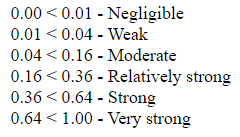

El efecto de la variable ratio de trabajo remoto parece ser moderado en el salario basado en el valor de epsilon cuadrado.

**Post-hoc**

In [ ]:
%%R
pairwise.wilcox.test(salarios$salario_usd, salarios$ratio_trabajo_remoto)


	Pairwise comparisons using Wilcoxon rank sum test with continuity correction 

data:  salarios$salario_usd and salarios$ratio_trabajo_remoto 

    0      50          
50  0.0014 -           
100 0.0144 0.0000000013

P value adjustment method: holm 


In [ ]:
%%R
dunnTest(salario_usd ~ ratio_trabajo_remoto, data=salarios)

R[write to console]: Dunn (1964) Kruskal-Wallis multiple comparison

R[write to console]:   p-values adjusted with the Holm method.




  Comparison         Z            P.unadj             P.adj
1    0 - 100 -2.445965 0.0144465083730456 0.014446508373046
2     0 - 50  3.384990 0.0007118085692562 0.001423617138512
3   100 - 50  6.244673 0.0000000004246889 0.000000001274067


En conclusión, existe evidencia para afirmar que los salarios entre trabajadores con diferentes ratios remotos tienen diferentes sueldos. Siendo mayor el de los que realizan trabajos remotos y menor el de los que lo hacen de manera semi presencial.

###Salario - Sede de la empresa

Para este caso se analizarán solo paises los cuales haya más de 5 observaciones para simplificar el analisis y evitar sacar conclusiones de un grupo del cuál se posee pocas observaciones.

In [ ]:
%%R
salarios_sed_filt <- salarios[with(salarios, sede_empresa %in% names(which(table(sede_empresa)>5))),c("sede_empresa","salario_usd") ]
str(salarios_sed_filt)

'data.frame':	530 obs. of  2 variables:
 $ sede_empresa: Factor w/ 50 levels "AE","AS","AT",..: 13 30 19 49 49 49 49 18 26 18 ...
 $ salario_usd : int  79833 260000 109024 150000 72000 190000 135000 51321 40481 39916 ...


In [ ]:
%%R
salarios_sed_filt$sede_empresa <- droplevels(salarios_sed_filt$sede_empresa)
table(salarios_sed_filt$sede_empresa)


 CA  DE  ES  FR  GB  GR  IN  JP  US 
 30  28  14  15  47  11  24   6 355 


**Analisis gráfico**

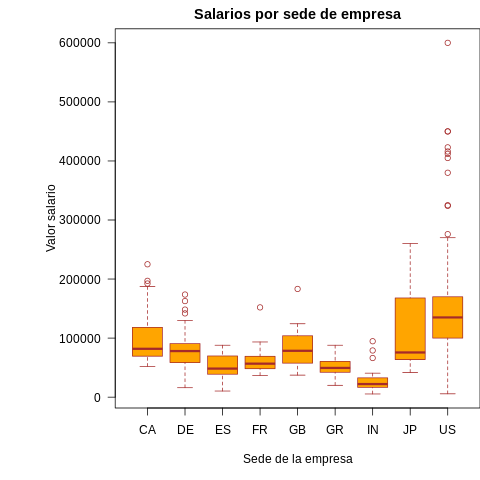

In [ ]:
%%R
par(mgp=c(3,1,0))
par(mar=c(5,8,2,0))
boxplot(salario_usd ~ sede_empresa, data =salarios_sed_filt,
                      main = "Salarios por sede de empresa",
                      xlab = "Sede de la empresa",
                      ylab = "Valor salario\n",
                      col = "orange",
                      border = "brown",
                      horizontal = FALSE,
                      notch = FALSE,
                      las = 1)

Gráficamente se observan mayores diferencias entre las empresas de India, Japon y Estados Unidos

**Tests para verificar normalidad**

In [ ]:
%%R
Test.SW=function(x){shapiro.test(x)$p.value}
aggregate(salario_usd ~ sede_empresa, data=salarios_sed_filt,FUN=Test.SW)

  sede_empresa               salario_usd
1           CA 0.00023443426087566186463
2           DE 0.04035359509673480671310
3           ES 0.86261099788169626201295
4           FR 0.00151158288166855286558
5           GB 0.01408880580157893629145
6           GR 0.96373532273784201507283
7           IN 0.00057459288958094489452
8           JP 0.10083689135027965044777
9           US 0.00000000000000003733515


Se observa que múltiples grupos no siguen una distribución normal por tener p-values menores a 0,05. Debido a esto se utiliza para la comparación al test de Kruskal-Wallis

In [ ]:
%%R
kruskal.test(salario_usd ~ sede_empresa, data=salarios_sed_filt)


	Kruskal-Wallis rank sum test

data:  salario_usd by sede_empresa
Kruskal-Wallis chi-squared = 197.86, df = 8, p-value <
0.00000000000000022



Como p-value<0.05 se puede rechazar la hipótesis nula y decir que existe diferencia entre los grupos, es decir que existe diferencia entre los salarios dependiendo del pais de sede de la empresa. Para explorar estas diferencias más en detalle se lleva a cabo un analisis de efecto, y tests post-hoc para cuantizar diferencias particulares entre 2 grupos.

**Analisis del efecto de la variable**

In [ ]:
%%R
sede_empresa <- epsilonSquared(x = salarios_sed_filt$salario_usd, g = salarios_sed_filt$sede_empresa)
efectos$sede_empresa <- sede_empresa
print(efectos$sede_empresa)

epsilon.squared 
          0.374 


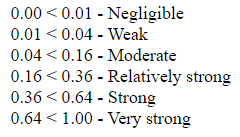

El efecto de la variable sede de la empresa parece ser fuerte en el salario basado en el valor de epsilon cuadrado.

**Post-hoc**

In [ ]:
%%R
pairwise.wilcox.test(salarios_sed_filt$salario_usd, salarios_sed_filt$sede_empresa)


	Pairwise comparisons using Wilcoxon rank sum test with continuity correction 

data:  salarios_sed_filt$salario_usd and salarios_sed_filt$sede_empresa 

   CA               DE               ES               FR              
DE 1.00000          -                -                -               
ES 0.00504          0.17678          -                -               
FR 0.01798          0.63600          1.00000          -               
GB 1.00000          1.00000          0.03095          0.28052         
GR 0.00748          0.17678          1.00000          1.00000         
IN 0.00000077042549 0.00006976726622 0.02254          0.00166         
JP 1.00000          1.00000          0.90898          1.00000         
US 0.00039          0.00000100860487 0.00000047383129 0.00000409743136
   GB               GR               IN               JP     
DE -                -                -                -      
ES -                -                -                -      
FR -                

Como los valores son bastantes se seleccionan las combinaciones que hayan presentado un p-value menor a 0.05 para encontrar las que son significativamente diferentes

In [ ]:
%%R
p_values <- pairwise.wilcox.test(salarios_sed_filt$salario_usd, salarios_sed_filt$sede_empresa)[[3]]
indices <- which(p_values<0.05)
indices1 <- dimnames(p_values)[[1]][(indices-1)%%8+1]
indices2 <- dimnames(p_values)[[2]][ceiling(indices/8)]
print(sort(paste(indices1," - ",indices2)))
sort(table(c(indices1,indices2)))

 [1] "ES  -  CA" "FR  -  CA" "GB  -  ES" "GR  -  CA" "GR  -  GB" "IN  -  CA"
 [7] "IN  -  DE" "IN  -  ES" "IN  -  FR" "IN  -  GB" "IN  -  GR" "JP  -  IN"
[13] "US  -  CA" "US  -  DE" "US  -  ES" "US  -  FR" "US  -  GB" "US  -  GR"
[19] "US  -  IN"

JP DE FR ES GB GR CA US IN 
 1  2  3  4  4  4  5  7  8 


Solo se encontró diferencia significativa en los salarios de las empresas con sede en Japón con las de India, la falta de diferencia con las demas observaciones puede deberse a la gran variedad en los sueldos de trabajadores de empresas japonesas, lo que puede visualizarse gráficamente en la gran amplitud de la caja en la gráfica

Se observa que salarios de trabajadores de empresas con sede en India poseen diferencias significativas con todos los demás, se puede decir que sus salarios son los más bajos.

De los salarios de empresas con sede en Estados unidos se encontraron diferencias significativas con casi todas las otras observaciones excepto con Japon. Se puede decir que las empresas con esta sede tienen trabajadores mejor remunerados. Algo similar sucede con las empresas con sede en Canadá

Para este caso sucede algo similar a lo ocurrido en la residencia del empleado, las empresas con sede en America del norte tienen trabajadores mejores remunerados que en Europa. Esto puede explicarse con el hecho de que es probable que la gran mayoría de gente que trabajan en una empresa tienen residencia igual a la sede de la empresa, esto se comprobará más adelante.






In [ ]:
%%R
filter(dunnTest(salario_usd ~ sede_empresa, data=salarios_sed_filt)[[2]],P.unadj<0.05)

   Comparison         Z                     P.unadj                      P.adj
1     CA - ES  2.662125 0.0077648986149622999455855 0.194122465374057501241722
2     CA - FR  2.136934 0.0326033286287976190043203 0.749876558462345244038261
3     CA - GR  2.505160 0.0122395927527117979322080 0.293750226065083164250780
4     CA - IN  4.212348 0.0000252729426041113940018 0.000758188278123341765843
5     DE - IN  3.101481 0.0019255498566388129771249 0.051989846129247951900254
6     GB - IN  3.366953 0.0007600376970912063471011 0.021281055518553776417789
7     ES - JP -1.979532 0.0477561363280897266392344 1.000000000000000000000000
8     IN - JP -2.755840 0.0058541570112114523632973 0.152208082291497764915178
9     CA - US -3.904002 0.0000946151047389165022073 0.002743838037428578645327
10    DE - US -5.263150 0.0000001416076485200712417 0.000004389837104122208864
11    ES - US -5.886390 0.0000000039472271728708071 0.000000134205723877607427
12    FR - US -5.379546 0.0000000746737402375927093 

In [ ]:
%%R
filter(dunnTest(salario_usd ~ sede_empresa, data=salarios_sed_filt)[[2]],P.adj<0.05)

  Comparison         Z                     P.unadj                      P.adj
1    CA - IN  4.212348 0.0000252729426041113940018 0.000758188278123341765843
2    GB - IN  3.366953 0.0007600376970912063471011 0.021281055518553776417789
3    CA - US -3.904002 0.0000946151047389165022073 0.002743838037428578645327
4    DE - US -5.263150 0.0000001416076485200712417 0.000004389837104122208864
5    ES - US -5.886390 0.0000000039472271728708071 0.000000134205723877607427
6    FR - US -5.379546 0.0000000746737402375927093 0.000002464233427840559367
7    GB - US -6.772015 0.0000000000127000967380248 0.000000000444503385830866
8    GR - US -5.308875 0.0000001103041686880298748 0.000003529733398016955992
9    IN - US -8.988971 0.0000000000000000002495563 0.000000000000000008984027


Se observan resultados similares a los obtenidos previamente

###Salario - Tamaño de empresa

**Analisis gráfico**

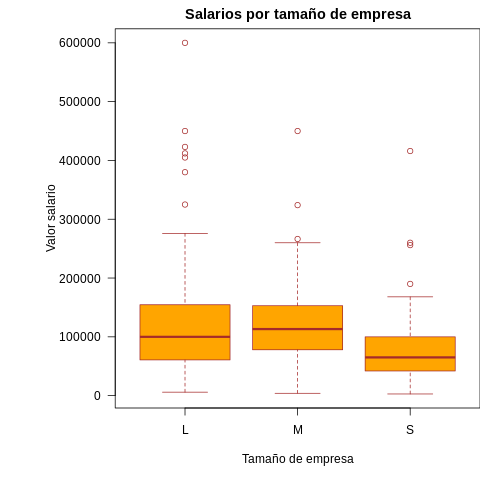

In [ ]:
%%R
par(mgp=c(3,1,0))
par(mar=c(5,8,2,0))
boxplot(salario_usd ~ tamaño_empresa, data =salarios,
                      main = "Salarios por tamaño de empresa",
                      xlab = "Tamaño de empresa",
                      ylab = "Valor salario\n",
                      col = "orange",
                      border = "brown",
                      horizontal = FALSE,
                      notch = FALSE,
                      las = 1)

Gráficamente parece existir diferencia entre los salarios de empresas pequeñas con los demás

**Tests para verificar normalidad**

In [ ]:
%%R
Test.SW=function(x){shapiro.test(x)$p.value}
aggregate(salario_usd ~ tamaño_empresa, data=salarios,FUN=Test.SW)

  tamaño_empresa           salario_usd
1              L 0.0000000000003669415
2              M 0.0000007938678313320
3              S 0.0000000042489238487


Ninguno de los 3 grupos sigue una distribución normal, por lo tanto se procede con el test de Kruskal-Wallis para compararlos.

In [ ]:
%%R
kruskal.test(salario_usd ~ tamaño_empresa, data=salarios)


	Kruskal-Wallis rank sum test

data:  salario_usd by tamaño_empresa
Kruskal-Wallis chi-squared = 36.411, df = 2, p-value = 0.0000000124



Como p-value<0.05 se puede rechazar la hipótesis nula y decir que existe diferencia entre los grupos, es decir que existe diferencia entre los salarios dependiendo del tamaño de la empresa. Para explorar estas diferencias más en detalle se lleva a cabo un analisis de efecto, y tests post-hoc para cuantizar diferencias particulares entre 2 grupos.

**Analisis del efecto de la variable**

In [ ]:
%%R
tamaño_empresa <- epsilonSquared(x = salarios$salario_usd, g = salarios$tamaño_empresa)
efectos$tamaño_empresa <- tamaño_empresa
print(efectos$tamaño_empresa)

epsilon.squared 
         0.0601 


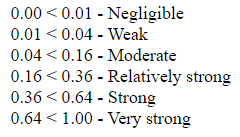

El efecto de la variable tamaño de empresa parece ser moderado en el salario basado en el valor de epsilon cuadrado.

**Post-hoc**

In [ ]:
%%R
pairwise.wilcox.test(salarios$salario_usd, salarios$tamaño_empresa)


	Pairwise comparisons using Wilcoxon rank sum test with continuity correction 

data:  salarios$salario_usd and salarios$tamaño_empresa 

  L            M           
M 0.22         -           
S 0.0000147595 0.0000000018

P value adjustment method: holm 


In [ ]:
%%R
dunnTest(salario_usd ~ tamaño_empresa, data=salarios)

R[write to console]: Dunn (1964) Kruskal-Wallis multiple comparison

R[write to console]:   p-values adjusted with the Holm method.




  Comparison         Z           P.unadj             P.adj
1      L - M -1.333951 0.182219999773962 0.182219999773962
2      L - S  4.744879 0.000002086308893 0.000004172617787
3      M - S  6.024105 0.000000001700476 0.000000005101427


En conclusión, existen diferencias entre los salarios de empresas pequeñas con las medianas y grandes, pero no entre las grandes y medianas.

###Salario - Cargo general

**Analisis gráfico**

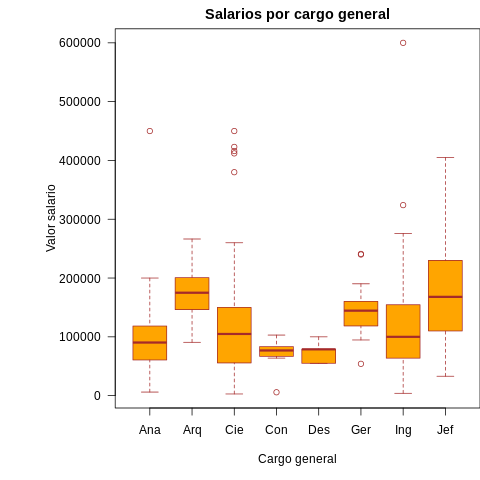

In [ ]:
%%R
par(mgp=c(3,1,0))
par(mar=c(5,8,2,0))
boxplot(salario_usd ~ cargo_general, data =salarios,
                      main = "Salarios por cargo general",
                      xlab = "Cargo general",
                      ylab = "Valor salario\n",
                      col = "orange",
                      names = c("Ana","Arq","Cie","Con","Des","Ger","Ing","Jef"),
                      border = "brown",
                      horizontal = FALSE,
                      notch = FALSE,
                      las = 1)

Gráficamente parece existir diferencia entre la mayoría de salarios por cargo

**Tests para verificar normalidad**

In [ ]:
%%R
Test.SW=function(x){shapiro.test(x)$p.value}
aggregate(salario_usd ~ cargo_general, data=salarios,FUN=Test.SW)

  cargo_general          salario_usd
1      Analista 0.000000000414445412
2    Arquitecto 0.898012752864753239
3    Cientifico 0.000000000116053010
4     Consultor 0.101742403714238441
5 Desarrollador 0.313583539128540312
6       Gerente 0.259615502317609326
7     Ingeniero 0.000000000007197793
8          Jefe 0.568881674337091803


No todos los grupos cumplen con la normalidad, no se cumple para el caso de salarios de Ingenieros, analistas y cientificos. Por eso se procede con el test de Kruskal-Wallis

In [ ]:
%%R
kruskal.test(salario_usd ~ tamaño_empresa, data=salarios)


	Kruskal-Wallis rank sum test

data:  salario_usd by tamaño_empresa
Kruskal-Wallis chi-squared = 36.411, df = 2, p-value = 0.0000000124



Como p-value<0.05 se puede rechazar la hipótesis nula y decir que existe diferencia entre los grupos, es decir que existe diferencia entre los salarios dependiendo del cargo que el trabajador ocupa. Para explorar estas diferencias más en detalle se lleva a cabo un analisis de efecto, y tests post-hoc para cuantizar diferencias particulares entre 2 grupos.

**Analisis del efecto de la variable**

In [ ]:
%%R
cargo_general <- epsilonSquared(x = salarios$salario_usd, g = salarios$cargo_general)
efectos$cargo_general <- cargo_general
print(efectos$cargo_general)

epsilon.squared 
         0.0759 


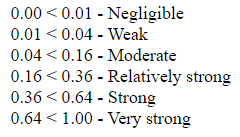

El efecto de la variable cargo general parece ser moderado en el salario basado en el valor de epsilon cuadrado.

**Post-hoc**

In [ ]:
%%R
pairwise.wilcox.test(salarios$salario_usd, salarios$cargo_general)


	Pairwise comparisons using Wilcoxon rank sum test with continuity correction 

data:  salarios$salario_usd and salarios$cargo_general 

              Analista Arquitecto Cientifico Consultor Desarrollador Gerente
Arquitecto    0.00029  -          -          -         -             -      
Cientifico    0.38178  0.03285    -          -         -             -      
Consultor     1.00000  0.01928    1.00000    -         -             -      
Desarrollador 1.00000  0.06297    1.00000    1.00000   -             -      
Gerente       0.00018  1.00000    0.10023    0.01355   0.05593       -      
Ingeniero     0.52045  0.02246    1.00000    1.00000   1.00000       0.07816
Jefe          0.00057  1.00000    0.02790    0.03465   0.07816       1.00000
              Ingeniero
Arquitecto    -        
Cientifico    -        
Consultor     -        
Desarrollador -        
Gerente       -        
Ingeniero     -        
Jefe          0.01454  

P value adjustment method: holm 


Como los valores son bastantes se seleccionan las combinaciones que hayan presentado un p-value menor a 0.05 para encontrar las que son significativamente diferentes

In [ ]:
%%R
p_values <- pairwise.wilcox.test(salarios$salario_usd, salarios$cargo_general)[[3]]
indices <- which(p_values<0.05)
indices1 <- dimnames(p_values)[[1]][(indices-1)%%7+1]
indices2 <- dimnames(p_values)[[2]][ceiling(indices/7)]
print(sort(paste(indices1," - ",indices2)))
sort(table(c(indices1,indices2)))

 [1] "Arquitecto  -  Analista"   "Cientifico  -  Arquitecto"
 [3] "Consultor  -  Arquitecto"  "Gerente  -  Analista"     
 [5] "Gerente  -  Consultor"     "Ingeniero  -  Arquitecto" 
 [7] "Jefe  -  Analista"         "Jefe  -  Cientifico"      
 [9] "Jefe  -  Consultor"        "Jefe  -  Ingeniero"       

Cientifico    Gerente  Ingeniero   Analista  Consultor Arquitecto       Jefe 
         2          2          2          3          3          4          4 


En conclusión se observa que los cargos que presentan mayor diferencias son los de arquitecto y jefe lo que indicaría que los trabajadores que ocupan esos cargos son los mejores remunerados. 

Los salarios de trabajadores con cargos de cientificos se diferencian en solamente con los de arquitectos y jefes lo que podría indicar que no son de los mejores remunerados.


In [ ]:
%%R
filter(dunnTest(salario_usd ~ cargo_general, data=salarios)[[2]],P.unadj<0.05)

                   Comparison         Z       P.unadj        P.adj
1       Analista - Arquitecto -4.086908 0.00004371601 0.0011803321
2       Analista - Cientifico -2.211462 0.02700388873 0.3510505535
3     Arquitecto - Cientifico  3.297608 0.00097512148 0.0195024296
4      Arquitecto - Consultor  3.502660 0.00046063735 0.0115159337
5  Arquitecto - Desarrollador  3.048010 0.00230362087 0.0414651757
6          Analista - Gerente -3.839604 0.00012323283 0.0032040535
7        Cientifico - Gerente -2.856846 0.00427873463 0.0641810194
8         Consultor - Gerente -3.087353 0.00201947572 0.0383700387
9     Desarrollador - Gerente -2.624814 0.00866963366 0.1213748712
10       Analista - Ingeniero -2.109465 0.03490443285 0.4188531942
11     Arquitecto - Ingeniero  3.376531 0.00073406215 0.0161493673
12        Gerente - Ingeniero  2.958931 0.00308708678 0.0524804753
13            Analista - Jefe -4.268095 0.00001971490 0.0005520171
14          Cientifico - Jefe -3.337784 0.00084449335 0.017734

In [ ]:
%%R
filter(dunnTest(salario_usd ~ cargo_general, data=salarios)[[2]],P.adj<0.05)

                   Comparison         Z       P.unadj        P.adj
1       Analista - Arquitecto -4.086908 0.00004371601 0.0011803321
2     Arquitecto - Cientifico  3.297608 0.00097512148 0.0195024296
3      Arquitecto - Consultor  3.502660 0.00046063735 0.0115159337
4  Arquitecto - Desarrollador  3.048010 0.00230362087 0.0414651757
5          Analista - Gerente -3.839604 0.00012323283 0.0032040535
6         Consultor - Gerente -3.087353 0.00201947572 0.0383700387
7      Arquitecto - Ingeniero  3.376531 0.00073406215 0.0161493673
8             Analista - Jefe -4.268095 0.00001971490 0.0005520171
9           Cientifico - Jefe -3.337784 0.00084449335 0.0177343603
10           Consultor - Jefe -3.383855 0.00071475822 0.0164394390
11           Ingeniero - Jefe -3.437224 0.00058770983 0.0141050359


Se observan resultados similares a los obtenidos previamente

##Relaciones cualitativas - cualitativas

###Nivel de experiencia - Sede de la empresa

Para este caso se analizarán solo paises los cuales haya más de 5 observaciones para simplificar el analisis y evitar sacar conclusiones de un grupo del cuál se posee pocas observaciones.

In [ ]:
%%R
salarios_sed_filt2 <- salarios[with(salarios, sede_empresa %in% names(which(table(sede_empresa)>5))),c("sede_empresa","nivel_experiencia") ]
str(salarios_sed_filt2)

'data.frame':	530 obs. of  2 variables:
 $ sede_empresa     : Factor w/ 50 levels "AE","AS","AT",..: 13 30 19 49 49 49 49 18 26 18 ...
 $ nivel_experiencia: Factor w/ 4 levels "EN","EX","MI",..: 3 4 4 4 1 4 3 1 3 1 ...


In [ ]:
%%R
salarios_sed_filt2$sede_empresa <- droplevels(salarios_sed_filt2$sede_empresa)
table(salarios_sed_filt2$sede_empresa)


 CA  DE  ES  FR  GB  GR  IN  JP  US 
 30  28  14  15  47  11  24   6 355 


**Analisis gráfico**

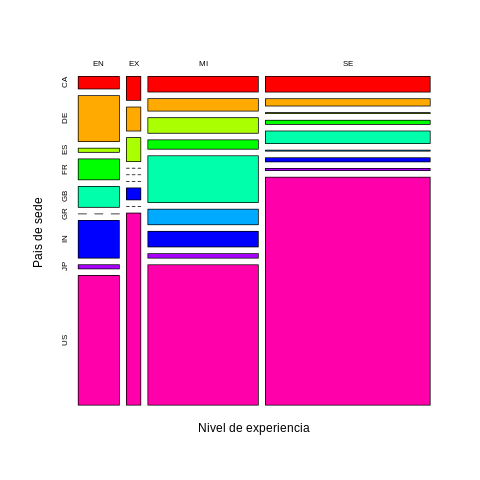

In [ ]:
%%R
mosaicplot(table(salarios_sed_filt2$nivel_experiencia, salarios_sed_filt2$sede_empresa),
           main="",
          color = rainbow(9),
          xlab = "Nivel de experiencia", # label for x-axis
          ylab = "Pais de sede" # label for y-axis
          )

Gráficamente se puede ver que en empresas de Estados unidos predominan trabajadores con niveles de experiencia de mayor jerarquia como senior o ejecutivos. En empresas de Gran Bretaña predominan trabajadores de nivel de experiencia intermedio. En empresas de Canadá resalta la cantidad de trabajadores de experiencia ejecutivo con respecto a los demas niveles.

In [ ]:
%%R
table(salarios_sed_filt2)

            nivel_experiencia
sede_empresa  EN  EX  MI  SE
          CA   3   2  10  15
          DE  11   2   8   7
          ES   1   2  10   1
          FR   5   0   6   4
          GB   5   0  30  12
          GR   0   0  10   1
          IN   9   1  10   4
          JP   1   0   3   2
          US  31  16  90 218


Como hay celdas con una frecuencia menor a 5 se deben agrupar algunas categórias, para este caso se agruparan por continente

In [ ]:
%%R
levels(salarios_sed_filt2$sede_empresa) <- c(levels(salarios_sed_filt2$sede_empresa),"europa","america_norte","asia")
salarios_sed_filt2[salarios_sed_filt2 == "DE"] <- "europa"
salarios_sed_filt2[salarios_sed_filt2 == "ES"] <- "europa"
salarios_sed_filt2[salarios_sed_filt2 == "FR"] <- "europa"
salarios_sed_filt2[salarios_sed_filt2 == "GB"] <- "europa"
salarios_sed_filt2[salarios_sed_filt2 == "GR"] <- "europa"
salarios_sed_filt2[salarios_sed_filt2 == "US"] <- "america_norte"
salarios_sed_filt2[salarios_sed_filt2 == "CA"] <- "america_norte"
salarios_sed_filt2[salarios_sed_filt2 == "JP"] <- "asia"
salarios_sed_filt2[salarios_sed_filt2 == "IN"] <- "asia"
salarios_sed_filt2$sede_empresa <- droplevels(salarios_sed_filt2$sede_empresa)
table(salarios_sed_filt2)

               nivel_experiencia
sede_empresa     EN  EX  MI  SE
  europa         22   4  64  25
  america_norte  34  18 100 233
  asia           10   1  13   6


Se decide finalmente eliminar la columna de ejecutivos ya que no se puede continuar agrupando y sigue habiendo menos de 5 observaciones

In [ ]:
%%R
salarios_sed_filt2 <- filter(salarios_sed_filt2, nivel_experiencia != "EX")
salarios_sed_filt2$nivel_experiencia <- droplevels(salarios_sed_filt2$nivel_experiencia)
table(salarios_sed_filt2)

               nivel_experiencia
sede_empresa     EN  MI  SE
  europa         22  64  25
  america_norte  34 100 233
  asia           10  13   6


In [ ]:
%%R
CrossTable(salarios_sed_filt2$nivel_experiencia, salarios_sed_filt2$sede_empresa, digits=2, prop.chisq=FALSE, asresid=TRUE, chisq=TRUE,format="SPSS")



   Cell Contents
|-------------------------|
|                   Count |
|             Row Percent |
|          Column Percent |
|           Total Percent |
|           Adj Std Resid |
|-------------------------|

Total Observations in Table:  507 

                                     | salarios_sed_filt2$sede_empresa 
salarios_sed_filt2$nivel_experiencia |        europa  | america_norte  |          asia  |     Row Total | 
-------------------------------------|---------------|---------------|---------------|---------------|
                                  EN |           22  |           34  |           10  |           66  | 
                                     |        33.33% |        51.52% |        15.15% |        13.02% | 
                                     |        19.82% |         9.26% |        34.48% |               | 
                                     |         4.34% |         6.71% |         1.97% |               | 
                                     |         2.41

Según el test hay una frecuencia esperada menor a 5, la cuál es la de trabajadores de empresas asiaticas de nivel senior, al no haber agrupamiento lógico se decide eliminar esa columna

In [ ]:
%%R
salarios_sed_filt2 <- filter(salarios_sed_filt2, sede_empresa != "asia")
salarios_sed_filt2$sede_empresa <- droplevels(salarios_sed_filt2$sede_empresa)
table(salarios_sed_filt2)

               nivel_experiencia
sede_empresa     EN  MI  SE
  europa         22  64  25
  america_norte  34 100 233


In [ ]:
%%R
CrossTable(salarios_sed_filt2$nivel_experiencia, salarios_sed_filt2$sede_empresa, digits=2, prop.chisq=FALSE, asresid=TRUE, chisq=TRUE,format="SPSS")


   Cell Contents
|-------------------------|
|                   Count |
|             Row Percent |
|          Column Percent |
|           Total Percent |
|           Adj Std Resid |
|-------------------------|

Total Observations in Table:  478 

                                     | salarios_sed_filt2$sede_empresa 
salarios_sed_filt2$nivel_experiencia |        europa  | america_norte  |     Row Total | 
-------------------------------------|---------------|---------------|---------------|
                                  EN |           22  |           34  |           56  | 
                                     |        39.29% |        60.71% |        11.72% | 
                                     |        19.82% |         9.26% |               | 
                                     |         4.60% |         7.11% |               | 
                                     |         3.03  |        -3.03  |               | 
-------------------------------------|---------------|------

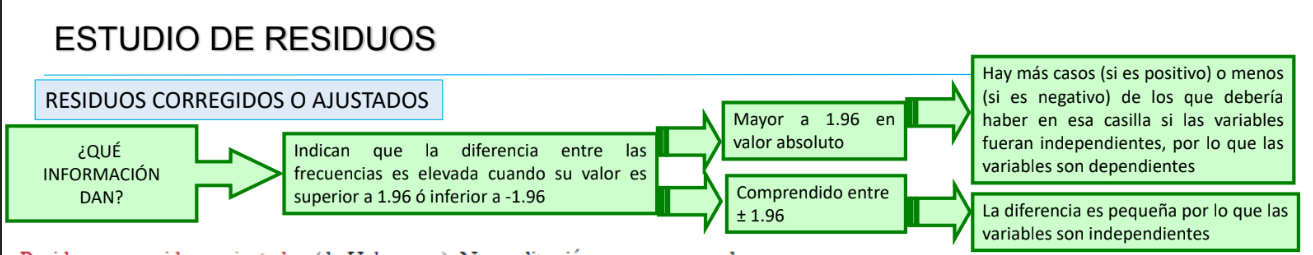

Basandose en el valor del test chi cuadrado se puede decir que existen asociacion entre las variables. Se observa que el nivel de experiencia predominante de empresas con sede en America del norte son de nivel senior, mientras que en el caso de las alojadas en Europa predominan trabajadores de nivel intermedio.

In [ ]:
%%R
ContCoef(salarios_sed_filt2$sede_empresa, salarios_sed_filt2$nivel_experiencia, correct = TRUE)

[1] 0.4636757


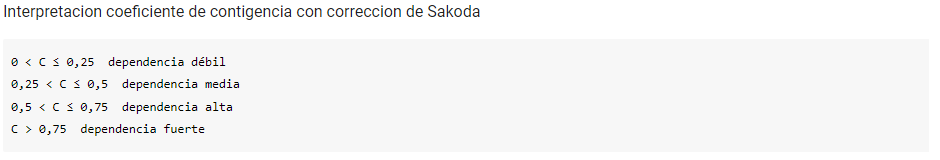

In [ ]:
%%R
CramerV(salarios_sed_filt2$sede_empresa, salarios_sed_filt2$nivel_experiencia)

[1] 0.347052


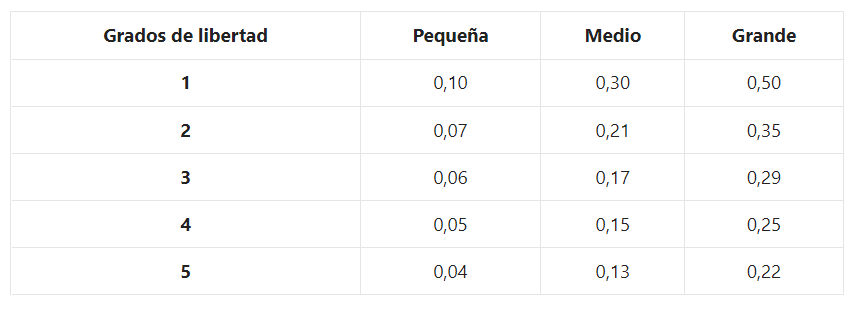

En base al coeficiente de contigencia se puede decir que la dependencia entre las variables es media y según el coeficiente de Cramer con 2 grados de libertad las variables poseen una asociación media/grande. 

En conclusión, las empresas con sede en America del norte tienen trabajadores de nivel senior y pocos de nivel intermedio y junior en comparación con las de Europa.

###Ratio de trabajo remoto - Residencia del empleado

Para este caso se analizará el ratio de trabajo remoto en contraste a la residencia del trabajador. Tomando solo residencias de paises donde haya disponible mas de 20 observaciones.

In [ ]:
%%R
salarios_res_filt2 <- salarios[with(salarios, residencia_empleado %in% names(which(table(residencia_empleado)>20))),c("residencia_empleado","ratio_trabajo_remoto") ]
str(salarios_res_filt2)

'data.frame':	460 obs. of  2 variables:
 $ residencia_empleado : Factor w/ 57 levels "AE","AR","AT",..: 15 21 56 56 56 56 28 56 56 28 ...
 $ ratio_trabajo_remoto: Factor w/ 3 levels "0","50","100": 1 2 2 3 3 3 1 3 3 2 ...


In [ ]:
%%R
salarios_res_filt2$residencia_empleado <- droplevels(salarios_res_filt2$residencia_empleado)
table(salarios_res_filt2$residencia_empleado)


 CA  DE  GB  IN  US 
 29  25  44  30 332 


**Analisis gráfico**

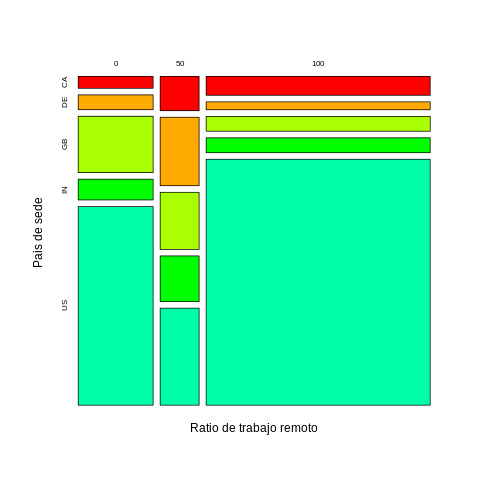

In [ ]:
%%R
mosaicplot(table(salarios_res_filt2$ratio_trabajo_remoto, salarios_res_filt2$residencia_empleado),
           main="",
          color = rainbow(9),
          xlab = "Ratio de trabajo remoto", # label for x-axis
          ylab = "Pais de sede" # label for y-axis
          )

Gráficamente se puede ver que trabajadores residentes de Estados unidos preferentemente trabajan de manera remota o presencial y no de manera semi-presencial. También se observa que la distribución por pais de los trabajadores que trabajan de manera semi presencial es similar, algo que no sucede en los otros casos.

In [ ]:
%%R
table(salarios_res_filt2)

                   ratio_trabajo_remoto
residencia_empleado   0  50 100
                 CA   4   6  19
                 DE   5  12   8
                 GB  19  10  15
                 IN   7   8  15
                 US  67  17 248


In [ ]:
%%R
CrossTable(salarios_res_filt2$ratio_trabajo_remoto, salarios_res_filt2$residencia_empleado, digits=2, prop.chisq=FALSE, asresid=TRUE, chisq=TRUE,format="SPSS")



   Cell Contents
|-------------------------|
|                   Count |
|             Row Percent |
|          Column Percent |
|           Total Percent |
|           Adj Std Resid |
|-------------------------|

Total Observations in Table:  460 

                                        | salarios_res_filt2$residencia_empleado 
salarios_res_filt2$ratio_trabajo_remoto |       CA  |       DE  |       GB  |       IN  |       US  | Row Total | 
----------------------------------------|-----------|-----------|-----------|-----------|-----------|-----------|
                                      0 |        4  |        5  |       19  |        7  |       67  |      102  | 
                                        |     3.92% |     4.90% |    18.63% |     6.86% |    65.69% |    22.17% | 
                                        |    13.79% |    20.00% |    43.18% |    23.33% |    20.18% |           | 
                                        |     0.87% |     1.09% |     4.13% |     1.52% |    

Se decide agrupar por continentes para intentar que no haya frecuencias esperadas menores a 5.

In [ ]:
%%R
levels(salarios_res_filt2$residencia_empleado) <- c(levels(salarios_res_filt2$residencia_empleado),"europa","america_norte","asia")
salarios_res_filt2[salarios_res_filt2 == "DE"] <- "europa"
salarios_res_filt2[salarios_res_filt2 == "GB"] <- "europa"
salarios_res_filt2[salarios_res_filt2 == "US"] <- "america_norte"
salarios_res_filt2[salarios_res_filt2 == "CA"] <- "america_norte"
salarios_res_filt2[salarios_res_filt2 == "IN"] <- "asia"
salarios_res_filt2$residencia_empleado <- droplevels(salarios_res_filt2$residencia_empleado)
table(salarios_res_filt2)

                   ratio_trabajo_remoto
residencia_empleado   0  50 100
      europa         24  22  23
      america_norte  71  23 267
      asia            7   8  15


In [ ]:
%%R
CrossTable(salarios_res_filt2$ratio_trabajo_remoto, salarios_res_filt2$residencia_empleado, digits=2, prop.chisq=FALSE, asresid=TRUE, chisq=TRUE,format="SPSS")


   Cell Contents
|-------------------------|
|                   Count |
|             Row Percent |
|          Column Percent |
|           Total Percent |
|           Adj Std Resid |
|-------------------------|

Total Observations in Table:  460 

                                        | salarios_res_filt2$residencia_empleado 
salarios_res_filt2$ratio_trabajo_remoto |        europa  | america_norte  |          asia  |     Row Total | 
----------------------------------------|---------------|---------------|---------------|---------------|
                                      0 |           24  |           71  |            7  |          102  | 
                                        |        23.53% |        69.61% |         6.86% |        22.17% | 
                                        |        34.78% |        19.67% |        23.33% |               | 
                                        |         5.22% |        15.43% |         1.52% |               | 
                       

Según el test hay una frecuencia esperada menor a 5, la cuál es la de trabajadores reisdentes en Asia que trabaja en modalidad semi-presencial, al no haber agrupamiento lógico se decide eliminar esa columna

In [ ]:
%%R
salarios_res_filt2 <- filter(salarios_res_filt2, residencia_empleado != "asia")
salarios_res_filt2$residencia_empleado <- droplevels(salarios_res_filt2$residencia_empleado)
table(salarios_res_filt2)

                   ratio_trabajo_remoto
residencia_empleado   0  50 100
      europa         24  22  23
      america_norte  71  23 267


In [ ]:
%%R
CrossTable(salarios_res_filt2$ratio_trabajo_remoto, salarios_res_filt2$residencia_empleado, digits=2, prop.chisq=FALSE, asresid=TRUE, chisq=TRUE,format="SPSS")


   Cell Contents
|-------------------------|
|                   Count |
|             Row Percent |
|          Column Percent |
|           Total Percent |
|           Adj Std Resid |
|-------------------------|

Total Observations in Table:  430 

                                        | salarios_res_filt2$residencia_empleado 
salarios_res_filt2$ratio_trabajo_remoto |        europa  | america_norte  |     Row Total | 
----------------------------------------|---------------|---------------|---------------|
                                      0 |           24  |           71  |           95  | 
                                        |        25.26% |        74.74% |        22.09% | 
                                        |        34.78% |        19.67% |               | 
                                        |         5.58% |        16.51% |               | 
                                        |         2.77  |        -2.77  |               | 
-----------------------------

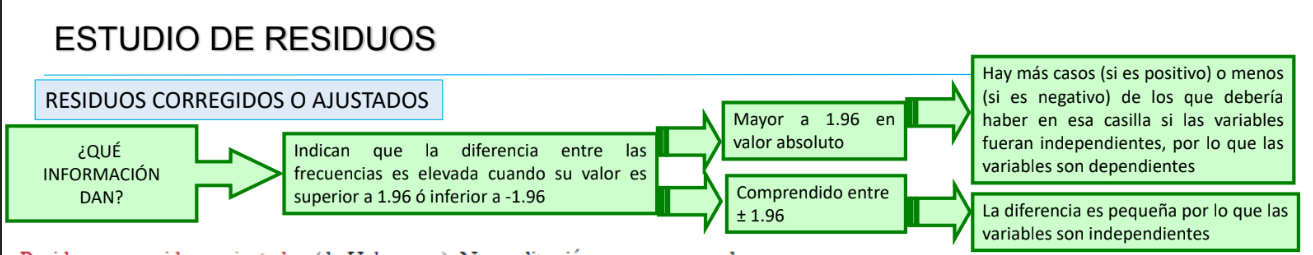

Basandose en el valor del test chi cuadrado se puede decir que existen asociacion entre las variables. Se observa que los trabajadores de América del norte mayoritariamente realizan su trabajo de manera remota, en cambio los de Europa están casi uniformemente distribuidos en modalidad. Tambien se aprecia que trabajadores que optan por modalidad semi presencial están equitativamente distribuidos entre Europa y Norteamerica

In [ ]:
%%R
ContCoef(salarios_res_filt2$residencia_empleado, salarios_res_filt2$ratio_trabajo_remoto, correct = TRUE)

[1] 0.4808044


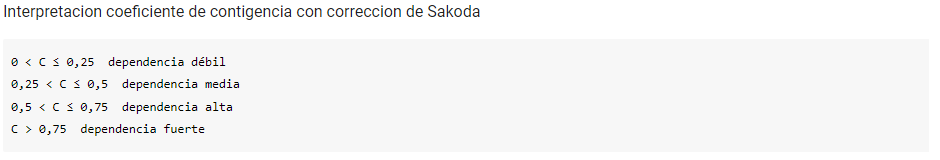

In [ ]:
%%R
CramerV(salarios_res_filt2$residencia_empleado, salarios_res_filt2$ratio_trabajo_remoto)

[1] 0.3615145


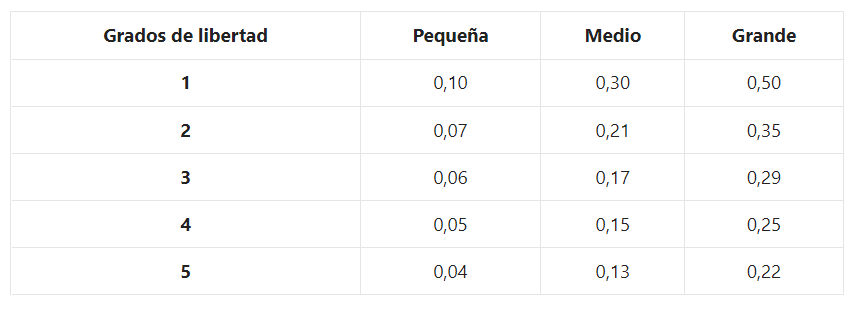

En base al coeficiente de contigencia se puede decir que la dependencia entre las variables es media y según el coeficiente de Cramer con 2 grados de libertad las variables poseen una asociación grande. 

En conclusión, los trabajadores de America del norte tienden a trabajar de manera remota y los de Europa no presentan ninguna tendencia.

###Sede de la empresa - Residencia del empleado

Para este caso se analizará la frecuencia con la que los trabajadores optan por ejercer en una empresa con sede en un país diferente al de su residencia. Se contemplarán todos los trabajadores independientemente de si trabajan de manera remota o no.

In [ ]:
%%R
salarios_res_filt3 <- select(mutate(salarios, trabaja_local = (paste(residencia_empleado) == paste(sede_empresa))),"residencia_empleado","sede_empresa","trabaja_local")
str(salarios_res_filt3)

'data.frame':	607 obs. of  3 variables:
 $ residencia_empleado: Factor w/ 57 levels "AE","AR","AT",..: 15 33 21 24 56 56 56 26 56 42 ...
 $ sede_empresa       : Factor w/ 50 levels "AE","AS","AT",..: 13 30 19 21 49 49 49 23 49 39 ...
 $ trabaja_local      : logi  TRUE TRUE TRUE TRUE TRUE TRUE ...


In [ ]:
%%R
salarios_res_filt3 <- salarios_res_filt3[with(salarios_res_filt3, residencia_empleado %in% names(which(table(residencia_empleado)>5))),c("residencia_empleado","trabaja_local") ]
str(salarios_res_filt3)

'data.frame':	531 obs. of  2 variables:
 $ residencia_empleado: Factor w/ 57 levels "AE","AR","AT",..: 15 33 21 56 56 56 56 20 28 20 ...
 $ trabaja_local      : logi  TRUE TRUE TRUE TRUE TRUE TRUE ...


In [ ]:
%%R
salarios_res_filt3$residencia_empleado <- droplevels(salarios_res_filt3$residencia_empleado)
print(table(salarios_res_filt3$residencia_empleado))


 BR  CA  DE  ES  FR  GB  GR  IN  JP  PK  PT  US 
  6  29  25  15  18  44  13  30   7   6   6 332 


In [ ]:
%%R
salarios_res_filt3 <- filter(salarios_res_filt3, residencia_empleado != "BR")
salarios_res_filt3$residencia_empleado <- droplevels(salarios_res_filt3$residencia_empleado)
table(salarios_res_filt3)

                   trabaja_local
residencia_empleado FALSE TRUE
                 CA     1   28
                 DE     2   23
                 ES     2   13
                 FR     4   14
                 GB     1   43
                 GR     2   11
                 IN     6   24
                 JP     1    6
                 PK     3    3
                 PT     2    4
                 US     2  330


In [ ]:
%%R
levels(salarios_res_filt3$residencia_empleado) <- c(levels(salarios_res_filt3$residencia_empleado),"europa","america_norte","asia")
salarios_res_filt3[salarios_res_filt3 == "DE"] <- "europa"
salarios_res_filt3[salarios_res_filt3 == "ES"] <- "europa"
salarios_res_filt3[salarios_res_filt3 == "FR"] <- "europa"
salarios_res_filt3[salarios_res_filt3 == "GB"] <- "europa"
salarios_res_filt3[salarios_res_filt3 == "GR"] <- "europa"
salarios_res_filt3[salarios_res_filt3 == "PT"] <- "europa"
salarios_res_filt3[salarios_res_filt3 == "US"] <- "america_norte"
salarios_res_filt3[salarios_res_filt3 == "CA"] <- "america_norte"
salarios_res_filt3[salarios_res_filt3 == "PK"] <- "asia"
salarios_res_filt3[salarios_res_filt3 == "JP"] <- "asia"
salarios_res_filt3[salarios_res_filt3 == "IN"] <- "asia"
salarios_res_filt3$residencia_empleado <- droplevels(salarios_res_filt3$residencia_empleado)
table(salarios_res_filt3)

                   trabaja_local
residencia_empleado FALSE TRUE
      europa           13  108
      america_norte     3  358
      asia             10   33


**Analisis gráfico**

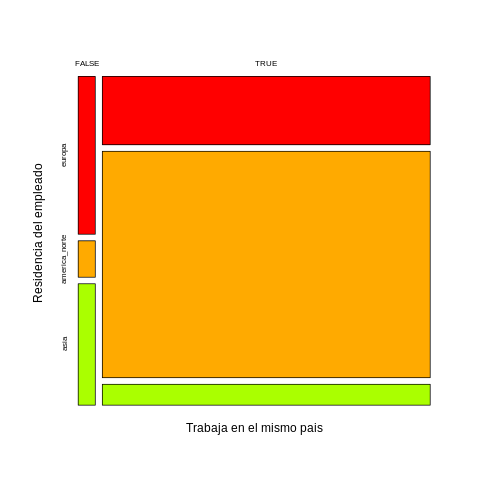

In [ ]:
%%R
mosaicplot(table(salarios_res_filt3$trabaja_local, salarios_res_filt3$residencia_empleado),
           main="",
          color = rainbow(9),
          xlab = "Trabaja en el mismo pais", # label for x-axis
          ylab = "Residencia del empleado" # label for y-axis
          )

Gráficamente se puede ver que trabajadores que trabajan en empresas fuera de su pais son mayoritariamente europeos o asiaticos.

In [ ]:
%%R
table(salarios_res_filt3)

                   trabaja_local
residencia_empleado FALSE TRUE
      europa           13  108
      america_norte     3  358
      asia             10   33


In [ ]:
%%R
CrossTable(salarios_res_filt3$trabaja_local, salarios_res_filt3$residencia_empleado, digits=2, prop.chisq=FALSE, asresid=TRUE, chisq=TRUE,format="SPSS")



   Cell Contents
|-------------------------|
|                   Count |
|             Row Percent |
|          Column Percent |
|           Total Percent |
|           Adj Std Resid |
|-------------------------|

Total Observations in Table:  525 

                                 | salarios_res_filt3$residencia_empleado 
salarios_res_filt3$trabaja_local |        europa  | america_norte  |          asia  |     Row Total | 
---------------------------------|---------------|---------------|---------------|---------------|
                           FALSE |           13  |            3  |           10  |           26  | 
                                 |        50.00% |        11.54% |        38.46% |         4.95% | 
                                 |        10.74% |         0.83% |        23.26% |               | 
                                 |         2.48% |         0.57% |         1.90% |               | 
                                 |         3.35  |        -6.46  |      

No se puede ejecutar el test debido a la baja frecuencia esperada y tampoco es viable la ejecución del test de fisher ni un agrupamiento lógico. Se puede concluir en base a la tabla de contingencias que los trabajadores que viven en Asia suelen ser los que tienden a trabajar para empresas fuera de su pais, caso totalmente contrario para los trabajadores de Norteamerica.

###Nivel de experiencia - Cargo general

In [ ]:
%%R
salarios_exp_filt <- select(salarios,nivel_experiencia,cargo_general)

**Analisis gráfico**

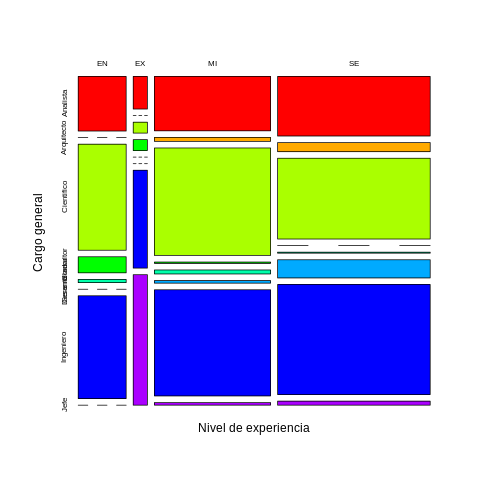

In [ ]:
%%R
mosaicplot(table(salarios_exp_filt$nivel_experiencia, salarios_exp_filt$cargo_general),
           main="",
          color = rainbow(9),
          xlab = "Nivel de experiencia", # label for x-axis
          ylab = "Cargo general" # label for y-axis
          )

In [ ]:
%%R
unique(salarios_exp_filt$cargo_general)

[1] Cientifico    Ingeniero     Analista      Consultor     Jefe         
[6] Gerente       Desarrollador Arquitecto   
8 Levels: Analista Arquitecto Cientifico Consultor Desarrollador ... Jefe


Gráficamente se puede ver que analistas y ingenieros tienen niveles de experiencia muy variados, los jefes son casi en su totalidad de nivel de experiencia ejecutivo, los cientificos están distribuidos de manera equitativa en los niveles de experiencia excepto en el nivel ejecutivo y los arquitectos son mayoritariamente de nivel senior e intermedio. Del resto de cargos hay pocas muestras y no puede verse claramente.

In [ ]:
%%R
table(salarios_exp_filt)

                 cargo_general
nivel_experiencia Analista Arquitecto Cientifico Consultor Desarrollador
               EN       17          0         33         5             1
               EX        3          0          1         1             0
               MI       41          3         81         1             3
               SE       59          9         80         0             1
                 cargo_general
nivel_experiencia Gerente Ingeniero Jefe
               EN       0        32    0
               EX       0         9   12
               MI       2        80    2
               SE      18       109    4


Se tomarán los 3 cargos de mayor cantidad de datos, es decir, cientifico, ingeniero y analista para intentar realizar un test chi cuadrado ya que pueden presentar frecuencias esperadas mayores a 5

In [ ]:
%%R
salarios_exp_filt <- filter(salarios_exp_filt, cargo_general == "Analista" | cargo_general == "Cientifico" | cargo_general == "Ingeniero")
salarios_exp_filt$cargo_general <- droplevels(salarios_exp_filt$cargo_general)
table(salarios_exp_filt)

                 cargo_general
nivel_experiencia Analista Cientifico Ingeniero
               EN       17         33        32
               EX        3          1         9
               MI       41         81        80
               SE       59         80       109


In [ ]:
%%R
CrossTable(salarios_exp_filt$nivel_experiencia, salarios_exp_filt$cargo_general, digits=2, prop.chisq=FALSE, asresid=TRUE, chisq=TRUE,format="SPSS")



   Cell Contents
|-------------------------|
|                   Count |
|             Row Percent |
|          Column Percent |
|           Total Percent |
|           Adj Std Resid |
|-------------------------|

Total Observations in Table:  545 

                                    | salarios_exp_filt$cargo_general 
salarios_exp_filt$nivel_experiencia |   Analista  | Cientifico  |  Ingeniero  |  Row Total | 
------------------------------------|------------|------------|------------|------------|
                                 EN |        17  |        33  |        32  |        82  | 
                                    |     20.73% |     40.24% |     39.02% |     15.05% | 
                                    |     14.17% |     16.92% |     13.91% |            | 
                                    |      3.12% |      6.06% |      5.87% |            | 
                                    |     -0.31  |      0.91  |     -0.63  |            | 
------------------------------------|--

Según el test hay algunas frecuencia esperada menor a 5, la cuál es la de trabajadores de nivel de experiencia ejecutiva, al no haber agrupamiento lógico se decide eliminar esa columna

In [ ]:
%%R
salarios_exp_filt <- filter(salarios_exp_filt, nivel_experiencia != "EX")
salarios_exp_filt$nivel_experiencia <- droplevels(salarios_exp_filt$nivel_experiencia)
table(salarios_exp_filt)

                 cargo_general
nivel_experiencia Analista Cientifico Ingeniero
               EN       17         33        32
               MI       41         81        80
               SE       59         80       109


In [ ]:
%%R
CrossTable(salarios_exp_filt$nivel_experiencia, salarios_exp_filt$cargo_general, digits=2, prop.chisq=FALSE, asresid=TRUE, chisq=TRUE,format="SPSS")



   Cell Contents
|-------------------------|
|                   Count |
|             Row Percent |
|          Column Percent |
|           Total Percent |
|           Adj Std Resid |
|-------------------------|

Total Observations in Table:  532 

                                    | salarios_exp_filt$cargo_general 
salarios_exp_filt$nivel_experiencia |   Analista  | Cientifico  |  Ingeniero  |  Row Total | 
------------------------------------|------------|------------|------------|------------|
                                 EN |        17  |        33  |        32  |        82  | 
                                    |     20.73% |     40.24% |     39.02% |     15.41% | 
                                    |     14.53% |     17.01% |     14.48% |            | 
                                    |      3.20% |      6.20% |      6.02% |            | 
                                    |     -0.30  |      0.77  |     -0.50  |            | 
------------------------------------|--

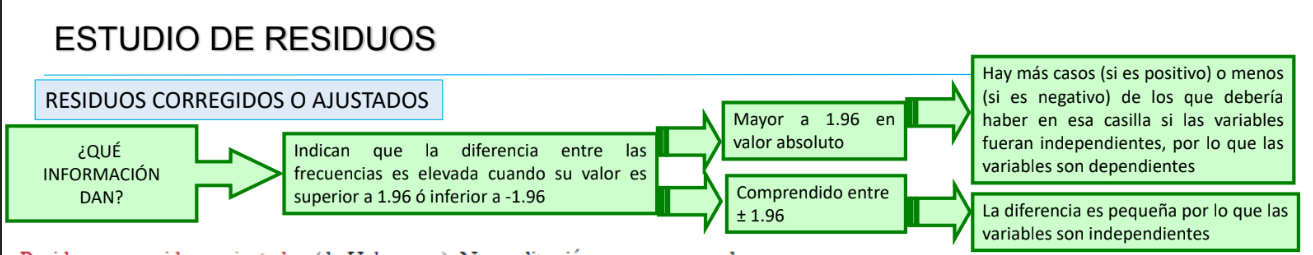

Basandose en el valor del test chi cuadrado se puede decir que no existen asociacion entre las variables. 

In [ ]:
%%R
pwr.chisq.test(w= cramerV(salarios_exp_filt$nivel_experiencia, salarios_exp_filt$cargo_general) , df=(4), N= 532, sig.level=0.05, power = NULL)


     Chi squared power calculation 

              w = 0.05815
              N = 532
             df = 4
      sig.level = 0.05
          power = 0.1575403

NOTE: N is the number of observations



In [ ]:
%%R
pwr.chisq.test(w= cramerV(salarios_exp_filt$nivel_experiencia, salarios_exp_filt$cargo_general) , df=(4), N= NULL, sig.level=0.05, power = 0.8)


     Chi squared power calculation 

              w = 0.05815
              N = 3529.664
             df = 4
      sig.level = 0.05
          power = 0.8

NOTE: N is the number of observations



Ejecutando calculos de potencia se ve que la potencia, es decir, la probabilidad de detectar una diferencia si existiese es de 15%, y para tener una potencia de al menos 80% se necesita una cantidad cercana a 3600 datos.

En conclusión, el nivel de experiencia no parece influir en el cargo general que un trabajador ocupa, algo que resulta contraintuitivo, puede deberse a las simplificaciones, es decir, a los cargos general que no se tuvieron en cuenta para poder utilizar el test chi cuadrado debido a las bajas frecuencias esperadas.

#Comparación de efectos con el pre analisis

In [ ]:
%%R
efectos2 <- data.frame(efectos)
print(efectos2)

                año_trabajado nivel_experiencia tipo_empleo moneda_remunerada
epsilon.squared        0.0771             0.314       0.037             0.331
                residencia_empleado ratio_trabajo_remoto sede_empresa
epsilon.squared               0.465               0.0662        0.374
                tamaño_empresa cargo_general
epsilon.squared         0.0601        0.0759


In [ ]:
%%R
efectos2 <- as.numeric( efectos2[1:9] )
print(efectos2)

[1] 0.0771 0.3140 0.0370 0.3310 0.4650 0.0662 0.3740 0.0601 0.0759


In [ ]:
%%R
efectos2 <- efectos2[c(1, 2, 3, 9, 4, 5, 6, 7, 8)]
print(efectos2)

[1] 0.0771 0.3140 0.0370 0.0759 0.3310 0.4650 0.0662 0.3740 0.0601


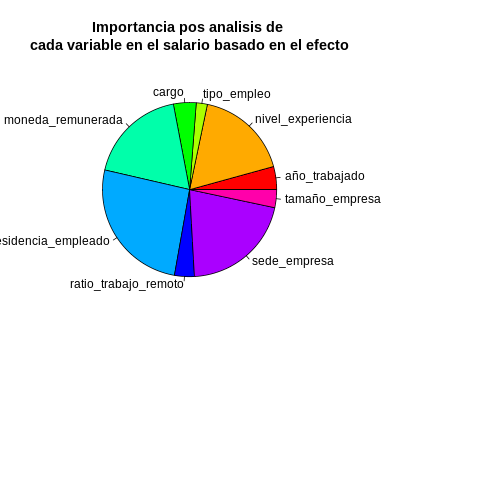

In [ ]:
%%R
par(mar=c(12,0,5,7))
pie(x = efectos2,
    main = "Importancia pos analisis de \ncada variable en el salario basado en el efecto",
    labels = c("año_trabajado","nivel_experiencia","tipo_empleo","cargo","moneda_remunerada",
               "residencia_empleado","ratio_trabajo_remoto","sede_empresa","tamaño_empresa"),
    col = rainbow(9))

Imagen anterior

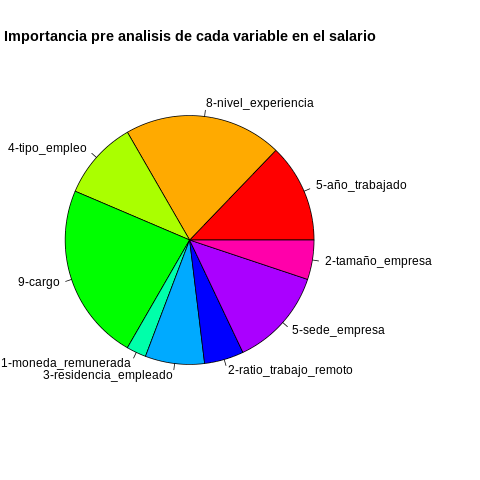

#Creación de variables continentes

In [ ]:
%%R
salarios <- mutate(salarios, sede_empresa_cont = c(countrycode(salarios$sede_empresa, origin = "iso2c", destination = "region"))) 
salarios <- mutate(salarios, residencia_empleado_cont = c(countrycode(salarios$residencia_empleado, origin = "iso2c", destination = "region"))) 
salarios$residencia_empleado_cont <- as.factor(salarios$residencia_empleado_cont)
salarios$sede_empresa_cont <- as.factor(salarios$sede_empresa_cont)

In [ ]:
%%R
print(table(salarios$residencia_empleado_cont))
print(table(salarios$sede_empresa_cont))

Se agruparan los registros africanos por ser muy pocos y se pondrán nombres más cortos

In [ ]:
%%R
levels(salarios$residencia_empleado_cont) <- c(levels(salarios$sede_empresa_cont),"OM&A","EA&P","E&AC","LA&C","NA","SA")
levels(salarios$sede_empresa_cont) <- c(levels(salarios$sede_empresa_cont),"OM&A","EA&P","E&AC","LA&C","NA","SA")
salarios[salarios == "Sub-Saharan Africa"] <- "OM&A"
salarios[salarios == "Middle East & North Africa"] <- "OM&A"
salarios[salarios == "East Asia & Pacific"] <- "EA&P"
salarios[salarios == "Europe & Central Asia"] <- "E&AC"
salarios[salarios == "Latin America & Caribbean"] <- "LA&C"
salarios[salarios == "North America"] <- "NA"
salarios[salarios == "South Asia"] <- "SA"
salarios$residencia_empleado_cont <- droplevels(salarios$residencia_empleado_cont)
salarios$sede_empresa_cont <- droplevels(salarios$sede_empresa_cont)

In [ ]:
%%R
print(table(salarios$residencia_empleado_cont))
print(table(salarios$sede_empresa_cont))

#Ampliación de analisis bivariado con dataset agrupado por continente

Se decidió analizar algunos aspectos del dataset nuevamente pero reemplazando las variables representadas en codigo de paises por regiones continentales, para intentar obtener información mas consistente. Se agregará el analisis de estás 2 nuevas variables (sede_empresa_continente y residencia_empleado_continente) con respecto al salario y se repetirán las 3 primeras relaciones cualitativas-cualitativas.

##Relaciones cuantitativas - cualitativas

###Salario - Residencia del empleado continente

**Analisis gráfico**

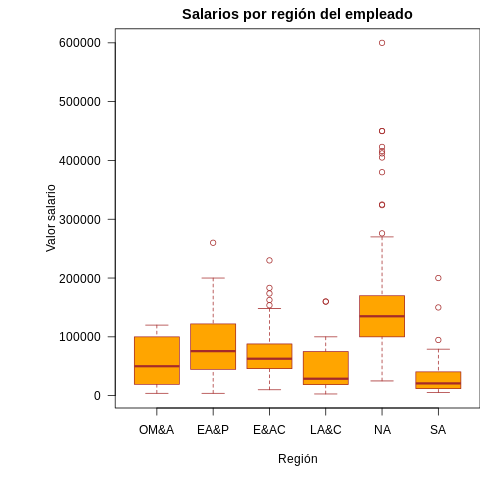

In [ ]:
%%R
par(mgp=c(3,1,0))
par(mar=c(5,8,2,0))
boxplot(salario_usd ~ residencia_empleado_cont, data =salarios,
                      main = "Salarios por región del empleado",
                      xlab = "Región",
                      ylab = "Valor salario\n",
                      col = "orange",
                      border = "brown",
                      horizontal = FALSE,
                      notch = FALSE,
                      las = 1)

Gráficamente parece haber una diferencia significativa entre los salarios por región, principalmente con la región de norteamerica y el sur de Asia. Se puede observar también que los outliers generales observados al analizar de manera univariada al salario que tenian valor mayor a 300000 se encuentran en la región de norteamerica.

**Tests para verificar normalidad**

In [ ]:
%%R
Test.SW=function(x){shapiro.test(x)$p.value}
aggregate(salario_usd ~ residencia_empleado_cont, data=salarios,FUN=Test.SW)

  residencia_empleado_cont               salario_usd
1                     OM&A 0.13319962259275827665128
2                     EA&P 0.02853854424882741255831
3                     E&AC 0.00000048538009420721374
4                     LA&C 0.00477162081581792695689
5                       NA 0.00000000000000000109101
6                       SA 0.00000016088636508782612


En los multiples grupos el p-value es menor a 0.05, por lo que estos grupos no siguen una distribución normal. Debido a esto se utiliza para la comparación al test de Kruskal-Wallis

In [ ]:
%%R
kruskal.test(salario_usd ~ residencia_empleado_cont, data=salarios)


	Kruskal-Wallis rank sum test

data:  salario_usd by residencia_empleado_cont
Kruskal-Wallis chi-squared = 273.87, df = 5, p-value <
0.00000000000000022



Como p-value<0.05 se puede rechazar la hipótesis nula y decir que existe diferencia entre los grupos, es decir que existe diferencia entre los salarios dependiendo del continente donde reside el empleado. Para explorar estas diferencias más en detalle se lleva a cabo tests post-hoc para cuantizar diferencias particulares entre 2 grupos.

**Post-hoc**

In [ ]:
%%R
pairwise.wilcox.test(salarios$salario_usd, salarios$residencia_empleado_cont)


	Pairwise comparisons using Wilcoxon rank sum test with continuity correction 

data:  salarios$salario_usd and salarios$residencia_empleado_cont 

     OM&A    EA&P    E&AC                 LA&C       NA                  
EA&P 0.89083 -       -                    -          -                   
E&AC 0.89083 0.89083 -                    -          -                   
LA&C 0.89083 0.18444 0.18444              -          -                   
NA   0.00017 0.00062 < 0.0000000000000002 0.00002039 -                   
SA   0.89083 0.00049 0.00000004           0.89083    < 0.0000000000000002

P value adjustment method: holm 


In [ ]:
%%R
p_values <- pairwise.wilcox.test(salarios$salario_usd, salarios$residencia_empleado_cont)[[3]]
indices <- which(p_values<0.05)
indices1 <- dimnames(p_values)[[1]][(indices-1)%%5+1]
indices2 <- dimnames(p_values)[[2]][ceiling(indices/5)]
print(sort(paste(indices1," - ",indices2)))
sort(table(c(indices1,indices2)))

[1] "NA  -  E&AC" "NA  -  EA&P" "NA  -  LA&C" "NA  -  OM&A" "SA  -  E&AC"
[6] "SA  -  EA&P" "SA  -  NA"  

LA&C OM&A E&AC EA&P   SA   NA 
   1    1    2    2    3    5 


In [ ]:
%%R
dunnTest(salario_usd ~ residencia_empleado_cont, data=salarios)

R[write to console]: Dunn (1964) Kruskal-Wallis multiple comparison

R[write to console]:   p-values adjusted with the Holm method.




    Comparison           Z                                           P.unadj
1  E&AC - EA&P  -1.5049217 0.13234421168846394190055093531555030494928359985
2  E&AC - LA&C   0.8287533 0.40724403434843453597480333883140701800584793091
3  EA&P - LA&C   1.6845865 0.09206837602261098985056975152474478818476200104
4    E&AC - NA -13.4603255 0.00000000000000000000000000000000000000002677343
5    EA&P - NA  -3.9551561 0.00007648470175740378236822064605959781147248577
6    LA&C - NA  -5.4905309 0.00000004007272722440259896363394629022203208280
7  E&AC - OM&A   0.3990386 0.68986478639230242038138385396450757980346679688
8  EA&P - OM&A   1.2802610 0.20045336509049693773931721807457506656646728516
9  LA&C - OM&A  -0.2641736 0.79164611667750284240696601045783609151840209961
10   NA - OM&A   4.5386621 0.00000566122792363265978148002474656941274133715
11   E&AC - SA   2.9873833 0.00281376661412791311683845307811679958831518888
12   EA&P - SA   3.2481209 0.00116169898446028463032120292552917817374691367

In [ ]:
%%R
filter(dunnTest(salario_usd ~ residencia_empleado_cont, data=salarios)[[2]],P.adj<0.05)

  Comparison          Z                                           P.unadj
1  E&AC - NA -13.460325 0.00000000000000000000000000000000000000002677343
2  EA&P - NA  -3.955156 0.00007648470175740378236822064605959781147248577
3  LA&C - NA  -5.490531 0.00000004007272722440259896363394629022203208280
4  NA - OM&A   4.538662 0.00000566122792363265978148002474656941274133715
5  E&AC - SA   2.987383 0.00281376661412791311683845307811679958831518888
6  EA&P - SA   3.248121 0.00116169898446028463032120292552917817374691367
7    NA - SA  10.381230 0.00000000000000000000000030186079627133190242085
                                             P.adj
1 0.0000000000000000000000000000000000000004016014
2 0.0008413317193314415924978999505867705011041835
3 0.0000005209454539172337534400167996517794222200
4 0.0000679347350835919139896285079416315966227558
5 0.0253238995271512189189078156914547435007989407
6 0.0116169898446028471705737672436953289434313774
7 0.0000000000000000000000042260511477986467257274


En conclusión, existe evidencia para afirmar diferencias entre Norteamerica y todas las demas regiones, indicando que los trabajadores con residencia allí tienen los salarios más altos. También hay evidencia de diferencia de la región del sur asiatico con la de Europa & Asia central y el este de Asia & Asia-pacifico lo que indica que los salarios allí son bajos en comparación con los de estas regiones.

###Salario - Sede de empresa continente

**Analisis gráfico**

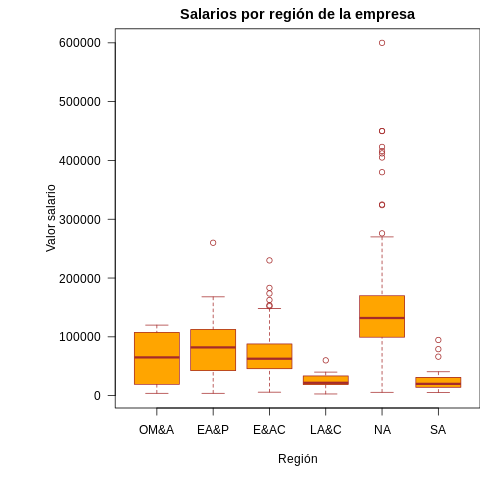

In [ ]:
%%R
par(mgp=c(3,1,0))
par(mar=c(5,8,2,0))
boxplot(salario_usd ~ sede_empresa_cont, data =salarios,
                      main = "Salarios por región de la empresa",
                      xlab = "Región",
                      ylab = "Valor salario\n",
                      col = "orange",
                      border = "brown",
                      horizontal = FALSE,
                      notch = FALSE,
                      las = 1)

Gráficamente se observa algo similar a lo ocurrido anteriormente pero aún mas marcada la diferencia entre las empresas con sede en norteamerica y las que estan en latinoamerica & el caribe y el sur de Asia

**Tests para verificar normalidad**

In [ ]:
%%R
Test.SW=function(x){shapiro.test(x)$p.value}
aggregate(salario_usd ~ sede_empresa_cont, data=salarios,FUN=Test.SW)

  sede_empresa_cont              salario_usd
1              OM&A 0.0647367654703994155341
2              EA&P 0.1024024945302033362537
3              E&AC 0.0000006235287938354597
4              LA&C 0.5763478388063442148237
5                NA 0.0000000000000000119682
6                SA 0.0001380873651903872157


En los multiples grupos el p-value es menor a 0.05, por lo que estos grupos no siguen una distribución normal. Debido a esto se utiliza para la comparación al test de Kruskal-Wallis

In [ ]:
%%R
kruskal.test(salario_usd ~ sede_empresa_cont, data=salarios)


	Kruskal-Wallis rank sum test

data:  salario_usd by sede_empresa_cont
Kruskal-Wallis chi-squared = 248.91, df = 5, p-value <
0.00000000000000022



Como p-value<0.05 se puede rechazar la hipótesis nula y decir que existe diferencia entre los grupos, es decir que existe diferencia entre los salarios dependiendo del continente donde está la sede de la empresa. Para explorar estas diferencias más en detalle se lleva a cabo tests post-hoc para cuantizar diferencias particulares entre 2 grupos.

**Post-hoc**

In [ ]:
%%R
pairwise.wilcox.test(salarios$salario_usd, salarios$sede_empresa_cont)


	Pairwise comparisons using Wilcoxon rank sum test with continuity correction 

data:  salarios$salario_usd and salarios$sede_empresa_cont 

     OM&A   EA&P   E&AC                 LA&C               NA                
EA&P 1.0000 -      -                    -                  -                 
E&AC 1.0000 0.9638 -                    -                  -                 
LA&C 0.5524 0.0123 0.0011               -                  -                 
NA   0.0018 0.0057 < 0.0000000000000002 0.0000085842765783 -                 
SA   0.2756 0.0017 0.0000000133628846   1.0000             0.0000000000000022

P value adjustment method: holm 


In [ ]:
%%R
p_values <- pairwise.wilcox.test(salarios$salario_usd, salarios$sede_empresa_cont)[[3]]
indices <- which(p_values<0.05)
indices1 <- dimnames(p_values)[[1]][(indices-1)%%5+1]
indices2 <- dimnames(p_values)[[2]][ceiling(indices/5)]
print(sort(paste(indices1," - ",indices2)))
sort(table(c(indices1,indices2)))

[1] "LA&C  -  E&AC" "LA&C  -  EA&P" "NA  -  E&AC"   "NA  -  EA&P"  
[5] "NA  -  LA&C"   "NA  -  OM&A"   "SA  -  E&AC"   "SA  -  EA&P"  
[9] "SA  -  NA"    

OM&A E&AC EA&P LA&C   SA   NA 
   1    3    3    3    3    5 


In [ ]:
%%R
dunnTest(salario_usd ~ sede_empresa_cont, data=salarios)

R[write to console]: Dunn (1964) Kruskal-Wallis multiple comparison

R[write to console]:   p-values adjusted with the Holm method.




    Comparison           Z                                      P.unadj
1  E&AC - EA&P  -1.2703829 0.203948256668460586871205464376544114202261
2  E&AC - LA&C   2.1311326 0.033078217096746027892084640598113765008748
3  EA&P - LA&C   2.5521558 0.010705861805820520230025927332917490275577
4    E&AC - NA -12.6403958 0.000000000000000000000000000000000001264159
5    EA&P - NA  -3.3644392 0.000766993802888652474215869236928710961365
6    LA&C - NA  -5.6991942 0.000000012037506081694894772933369215227317
7  E&AC - OM&A  -0.1084155 0.913666126293424696314104949124157428741455
8  EA&P - OM&A   0.7643897 0.444635073880032760662572854926111176609993
9  LA&C - OM&A  -1.6998064 0.089167346279444947843018098865286447107792
10   NA - OM&A   3.7862847 0.000152916490056553860303958924937717256398
11   E&AC - SA   3.3579096 0.000785343043120552680019796909505203075241
12   EA&P - SA   3.2714971 0.001069796818976336862105913638743004412390
13   LA&C - SA  -0.0812096 0.93527526359715262849192640715045854

In [ ]:
%%R
filter(dunnTest(salario_usd ~ sede_empresa_cont, data=salarios)[[2]],P.adj<0.05)

  Comparison          Z                                      P.unadj
1  E&AC - NA -12.640396 0.000000000000000000000000000000000001264159
2  EA&P - NA  -3.364439 0.000766993802888652474215869236928710961365
3  LA&C - NA  -5.699194 0.000000012037506081694894772933369215227317
4  NA - OM&A   3.786285 0.000152916490056553860303958924937717256398
5  E&AC - SA   3.357910 0.000785343043120552680019796909505203075241
6  EA&P - SA   3.271497 0.001069796818976336862105913638743004412390
7    NA - SA   9.496244 0.000000000000000000002175982974685578995800
                                        P.adj
1 0.00000000000000000000000000000000001896239
2 0.00843693183177517645743304086636271676980
3 0.00000015648757906203362212196644916162303
4 0.00183499788067864643206772434780305047752
5 0.00785343043120552766755970708345557795838
6 0.00962817137078703089159148476028349250555
7 0.00000000000000000003046376164559810518888


En conclusión, se observan diferencias similares a las de la comparación anterior, existe evidencia para afirmar diferencias entre Norteamerica y todas las demas regiones, indicando que los trabajadores de empresas de allí tienen los salarios más altos. También se ven diferencias entre algunas regiones con las de Latinoamerica & Caribe y el sur Asiatico que parecen ser de allí las empresas con peor remuneración.

##Relaciones cualitativas - cualitativas

###Nivel de experiencia - Sede de la empresa continente

**Analisis gráfico**

In [ ]:
%%R
salarios_cont_filt <- select(salarios,nivel_experiencia,sede_empresa_cont)

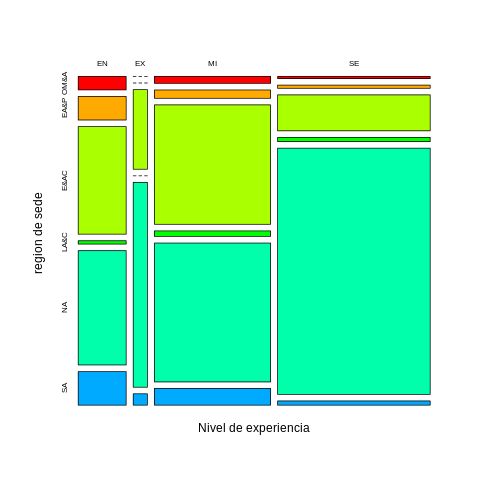

In [ ]:
%%R
mosaicplot(table(salarios_cont_filt$nivel_experiencia, salarios_cont_filt$sede_empresa_cont),
           main="",
          color = rainbow(9),
          xlab = "Nivel de experiencia", # label for x-axis
          ylab = "region de sede" # label for y-axis
          )

Gráficamente se puede ver que en empresas de Estados unidos predominan trabajadores con niveles de experiencia de mayor jerarquia como senior o ejecutivos. En empresas de Europa & Asia central no parece haber un tipo de experiencia que predomine pero si hay pocos de nivel senior. Los trabajadores de tipo ejecutivo tienen la distribución mas desbalanceada, concentrados casi en su totalidad en empresas de norteamerica y Europa & Asia central. Los trabajadores senior parecen concentrados principalmente en norteamerica

In [ ]:
%%R
table(salarios_cont_filt)

                 sede_empresa_cont
nivel_experiencia OM&A EA&P E&AC LA&C  NA  SA
               EN    4    7   32    1  34  10
               EX    0    0    7    0  18   1
               MI    5    6   86    4 100  12
               SE    2    3   34    4 233   4


Como hay celdas con una frecuencia menor a 5 se deben agrupar algunas categórias, para este caso se agruparan por continente. Se eliminirán los datos de latinoamerica por considerarse muy distintos para agrupar con America del norte y los de Oriente medio & Africa por no poder agruparse de manera lógica

In [ ]:
%%R
salarios_cont_filt <- filter(salarios_cont_filt, sede_empresa_cont != "LA&C" & sede_empresa_cont != "OM&A")
levels(salarios_cont_filt$sede_empresa_cont) <- c(levels(salarios_cont_filt$sede_empresa_cont),"europa&asiaC","america_norte","asia")
salarios_cont_filt[salarios_cont_filt == "E&AC"] <- "europa&asiaC"
salarios_cont_filt[salarios_cont_filt == "NA"] <- "america_norte"
salarios_cont_filt[salarios_cont_filt == "EA&P"] <- "asia"
salarios_cont_filt[salarios_cont_filt == "SA"] <- "asia"
salarios_cont_filt$sede_empresa_cont <- droplevels(salarios_cont_filt$sede_empresa_cont)
table(salarios_cont_filt)

                 sede_empresa_cont
nivel_experiencia europa&asiaC america_norte asia
               EN           32            34   17
               EX            7            18    1
               MI           86           100   18
               SE           34           233    7


Se decide finalmente eliminar la columna de ejecutivos ya que no se puede continuar agrupando y sigue habiendo menos de 5 observaciones

In [ ]:
%%R
salarios_cont_filt <- filter(salarios_cont_filt, nivel_experiencia != "EX")
salarios_cont_filt$nivel_experiencia <- droplevels(salarios_cont_filt$nivel_experiencia)
table(salarios_cont_filt)

                 sede_empresa_cont
nivel_experiencia europa&asiaC america_norte asia
               EN           32            34   17
               MI           86           100   18
               SE           34           233    7


In [ ]:
%%R
CrossTable(salarios_cont_filt$nivel_experiencia, salarios_cont_filt$sede_empresa_cont, digits=2, prop.chisq=FALSE, asresid=TRUE, chisq=TRUE,format="SPSS")



   Cell Contents
|-------------------------|
|                   Count |
|             Row Percent |
|          Column Percent |
|           Total Percent |
|           Adj Std Resid |
|-------------------------|

Total Observations in Table:  561 

                                     | salarios_cont_filt$sede_empresa_cont 
salarios_cont_filt$nivel_experiencia |  europa&asiaC  | america_norte  |          asia  |     Row Total | 
-------------------------------------|---------------|---------------|---------------|---------------|
                                  EN |           32  |           34  |           17  |           83  | 
                                     |        38.55% |        40.96% |        20.48% |        14.80% | 
                                     |        21.05% |         9.26% |        40.48% |               | 
                                     |         5.70% |         6.06% |         3.03% |               | 
                                     |        

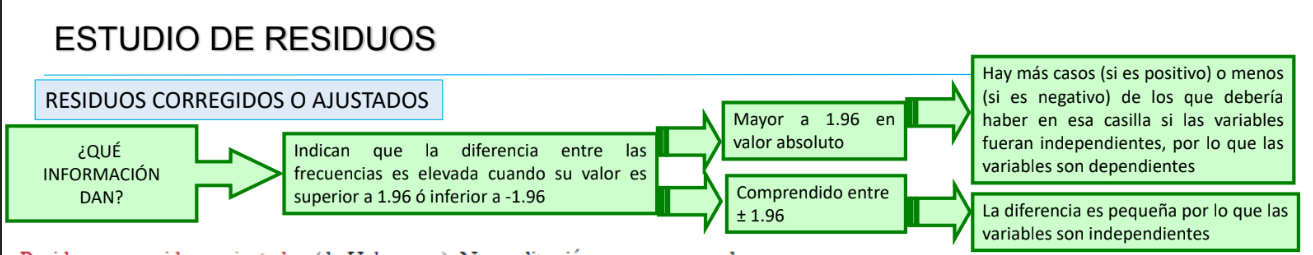

Basandose en el valor del test chi cuadrado se puede decir que existen asociacion entre las variables. Se observa que en cada región predomina un nivel de experiencia, en Asia los de nivel junior, el Europa & Asia Central los de nivel intermedio y en America del norte los de nivel senior.

In [ ]:
%%R
ContCoef(salarios_cont_filt$sede_empresa_cont, salarios_cont_filt$nivel_experiencia, correct = TRUE)

[1] 0.482607


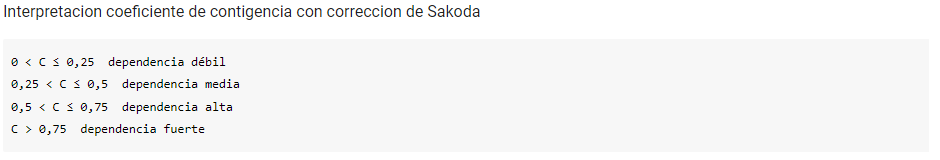

In [ ]:
%%R
CramerV(salarios_cont_filt$sede_empresa_cont, salarios_cont_filt$nivel_experiencia)

[1] 0.303162


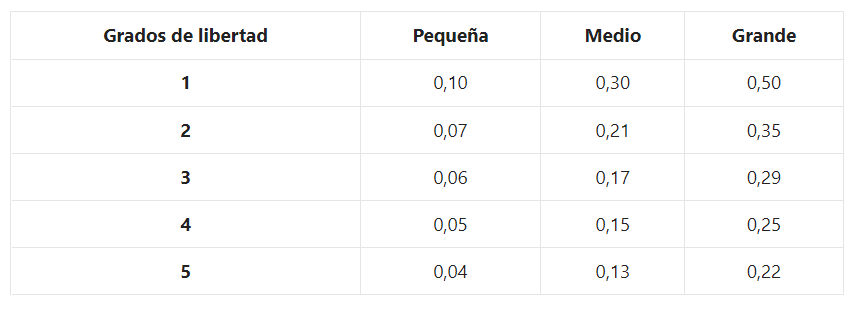

En base al coeficiente de contigencia se puede decir que la dependencia entre las variables es media y según el coeficiente de Cramer con 4 grados de libertad las variables poseen una asociación grande. 

In [ ]:
%%R
pwr.chisq.test(w= cramerV(salarios_cont_filt$sede_empresa_cont, salarios_cont_filt$nivel_experiencia) , df=(4), N= 561, sig.level=0.05, power = NULL)


     Chi squared power calculation 

              w = 0.3032
              N = 561
             df = 4
      sig.level = 0.05
          power = 0.9999949

NOTE: N is the number of observations



En cuanto a la potencia del test se observa que es casi 1, lo que indica que la probabilidad de cometer un error y que no exista diferencias significativas es casi nula.

En conclusión, las empresas con sede en America del norte tienen gran cantidad trabajadores de nivel senior y pocos de nivel intermedio y junior en comparación con las de Europa & Asia Central y Asia, donde en Europa & Asia Central se encontró una predominancia por trabajadores de nivel intermedio y una también una frecuencia elevada en trabajadores de nivel junior, finalmente en Asia predominan los trabajadores de junior, también hay una gran cantidad de trabajadores de nivel intermedio y muy pocos de nivel senior.

###Ratio de trabajo remoto - Residencia del empleado continente

Para este caso se analizará el ratio de trabajo remoto en contraste a la residencia del trabajador. Tomando solo residencias de paises donde haya disponible mas de 20 observaciones.

In [ ]:
%%R
salarios_cont_filt2 <- select(salarios,ratio_trabajo_remoto,residencia_empleado_cont)

**Analisis gráfico**

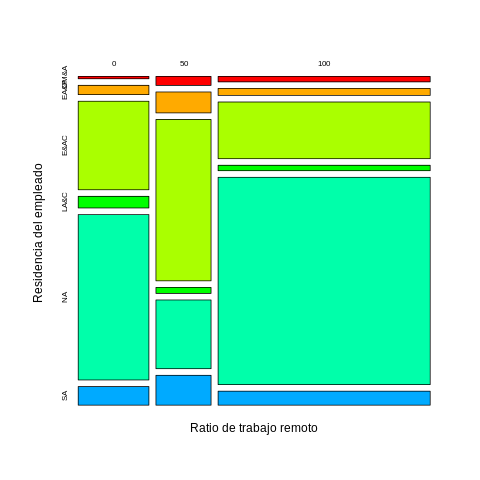

In [ ]:
%%R
mosaicplot(table(salarios_cont_filt2$ratio_trabajo_remoto, salarios_cont_filt2$residencia_empleado_cont),
           main="",
          color = rainbow(9),
          xlab = "Ratio de trabajo remoto", # label for x-axis
          ylab = "Residencia del empleado" # label for y-axis
          )

Gráficamente se puede ver que trabajadores residentes de Estados unidos preferentemente trabajan de manera remota o presencial y no de manera semi-presencial, todo lo contrario a los trabajadores de Europa & Asia Central. En el rsto de paises de residencia la distribución de ratio de trabajo remoto es casi uniforme.

In [ ]:
%%R
table(salarios_cont_filt2)

                    residencia_empleado_cont
ratio_trabajo_remoto OM&A EA&P E&AC LA&C  NA  SA
                 0      1    4   38    5  71   8
                 50     3    7   54    2  23  10
                 100    7    9   73    7 267  18


In [ ]:
%%R
CrossTable(salarios_cont_filt2$ratio_trabajo_remoto, salarios_cont_filt2$residencia_empleado_cont, digits=2, prop.chisq=FALSE, asresid=TRUE, chisq=TRUE,format="SPSS")



   Cell Contents
|-------------------------|
|                   Count |
|             Row Percent |
|          Column Percent |
|           Total Percent |
|           Adj Std Resid |
|-------------------------|

Total Observations in Table:  607 

                                         | salarios_cont_filt2$residencia_empleado_cont 
salarios_cont_filt2$ratio_trabajo_remoto |     OM&A  |     EA&P  |     E&AC  |     LA&C  |       NA  |       SA  | Row Total | 
-----------------------------------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
                                       0 |        1  |        4  |       38  |        5  |       71  |        8  |      127  | 
                                         |     0.79% |     3.15% |    29.92% |     3.94% |    55.91% |     6.30% |    20.92% | 
                                         |     9.09% |    20.00% |    23.03% |    35.71% |    19.67% |    22.22% |           | 
                     

Se decide agrupar de igual manera que anteriormente

In [ ]:
%%R
salarios_cont_filt2 <- filter(salarios_cont_filt2, residencia_empleado_cont != "LA&C" &  residencia_empleado_cont != "OM&A")
levels(salarios_cont_filt2$residencia_empleado_cont) <- c(levels(salarios_cont_filt2$residencia_empleado_cont),"europa&asiaC","america_norte","asia")
salarios_cont_filt2[salarios_cont_filt2 == "E&AC"] <- "europa&asiaC"
salarios_cont_filt2[salarios_cont_filt2 == "NA"] <- "america_norte"
salarios_cont_filt2[salarios_cont_filt2 == "EA&P"] <- "asia"
salarios_cont_filt2[salarios_cont_filt2 == "SA"] <- "asia"
salarios_cont_filt2$residencia_empleado_cont <- droplevels(salarios_cont_filt2$residencia_empleado_cont)
table(salarios_cont_filt2)

                    residencia_empleado_cont
ratio_trabajo_remoto europa&asiaC america_norte asia
                 0             38            71   12
                 50            54            23   17
                 100           73           267   27


In [ ]:
%%R
CrossTable(salarios_cont_filt2$ratio_trabajo_remoto, salarios_cont_filt2$residencia_empleado_cont, digits=2, prop.chisq=FALSE, asresid=TRUE, chisq=TRUE,format="SPSS")



   Cell Contents
|-------------------------|
|                   Count |
|             Row Percent |
|          Column Percent |
|           Total Percent |
|           Adj Std Resid |
|-------------------------|

Total Observations in Table:  582 

                                         | salarios_cont_filt2$residencia_empleado_cont 
salarios_cont_filt2$ratio_trabajo_remoto |  europa&asiaC  | america_norte  |          asia  |     Row Total | 
-----------------------------------------|---------------|---------------|---------------|---------------|
                                       0 |           38  |           71  |           12  |          121  | 
                                         |        31.40% |        58.68% |         9.92% |        20.79% | 
                                         |        23.03% |        19.67% |        21.43% |               | 
                                         |         6.53% |        12.20% |         2.06% |               | 
          

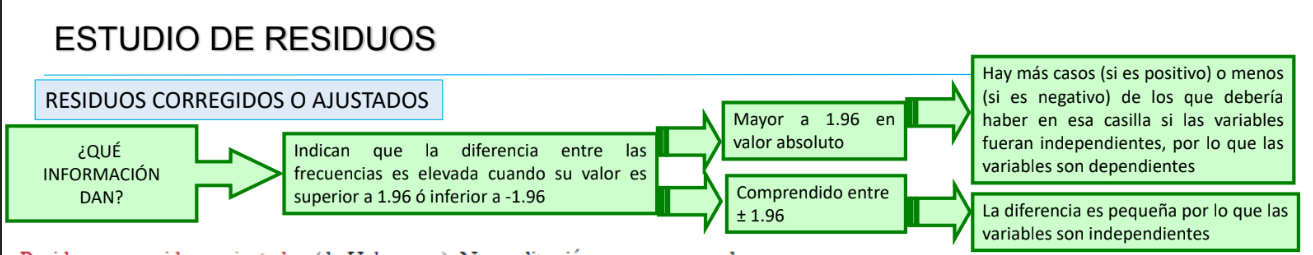

Basandose en el valor del test chi cuadrado se puede decir que existen asociacion entre las variables. Se observa que es significativamente superior la cantidad de trabajadores de América del norte que realizan su trabajo de manera remota e inferior la que lo hace de semiremota, en cambio en los de Europa & Asia central ocurre lo contrario, esto también ocurre con los trabajadores de Asia pero en menor medida.

In [ ]:
%%R
ContCoef(salarios_cont_filt2$residencia_empleado_cont, salarios_cont_filt2$ratio_trabajo_remoto, correct = TRUE)

[1] 0.4140469


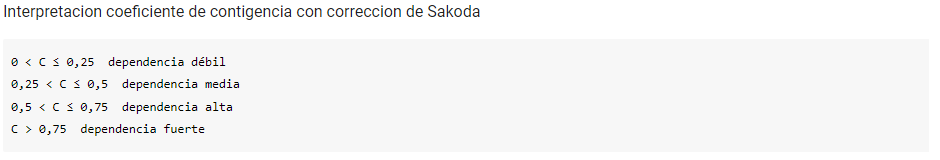

In [ ]:
%%R
CramerV(salarios_cont_filt2$residencia_empleado_cont, salarios_cont_filt2$ratio_trabajo_remoto)

[1] 0.2540055


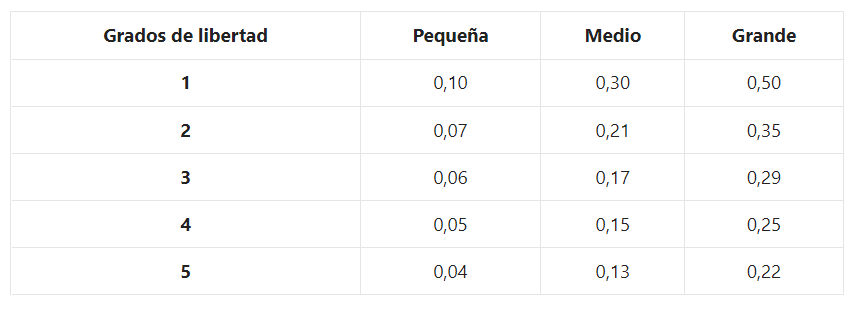

En base al coeficiente de contigencia se puede decir que la dependencia entre las variables es media y según el coeficiente de Cramer con 4 grados de libertad las variables poseen una asociación grande. 

In [ ]:
%%R
pwr.chisq.test(w= CramerV(salarios_cont_filt2$residencia_empleado_cont, salarios_cont_filt2$ratio_trabajo_remoto) , df=(4), N= 582, sig.level=0.05, power = NULL)


     Chi squared power calculation 

              w = 0.2540055
              N = 582
             df = 4
      sig.level = 0.05
          power = 0.9996504

NOTE: N is the number of observations



En cuanto a la potencia del test se observa que es casi 1, lo que indica que la probabilidad de cometer un error y que no exista diferencias significativas es casi nula.

En conclusión, los trabajadores de America del norte tienden a trabajar de manera remota por sobre semi presencial y los de Europa & Asia central y Asia prefieren hacerlo de manera semi presencial a remoto.

###Sede de la empresa continente- Residencia del empleado continente

Para este caso se analizará la frecuencia con la que los trabajadores optan por ejercer en una empresa con sede en una región diferente al de su residencia. Se contemplarán todos los trabajadores independientemente de si trabajan de manera remota o no.

In [ ]:
%%R
salarios_cont_filt3 <- select(mutate(salarios, trabaja_local = (paste(residencia_empleado_cont) == paste(sede_empresa_cont))),"residencia_empleado_cont","trabaja_local")
str(salarios_cont_filt3)

'data.frame':	607 obs. of  2 variables:
 $ residencia_empleado_cont: Factor w/ 6 levels "OM&A","EA&P",..: 3 2 3 4 5 5 5 3 5 2 ...
 $ trabaja_local           : logi  TRUE TRUE TRUE TRUE TRUE TRUE ...


**Analisis gráfico**

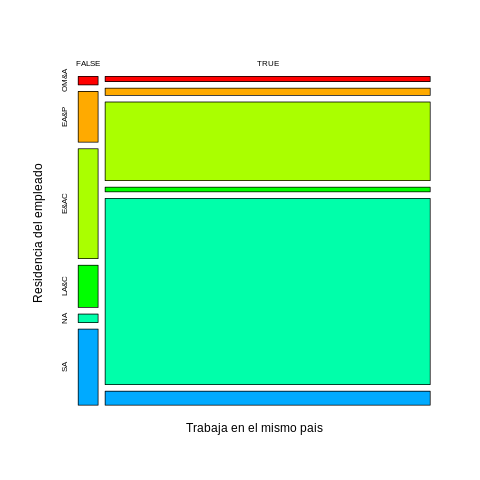

In [ ]:
%%R
mosaicplot(table(salarios_cont_filt3$trabaja_local, salarios_cont_filt3$residencia_empleado_cont),
           main="",
          color = rainbow(9),
          xlab = "Trabaja en el mismo pais", # label for x-axis
          ylab = "Residencia del empleado" # label for y-axis
          )

Gráficamente se puede ver que trabajadores que en casi todas las regiones se opta por trabajar afuera de su región, excepto en Norteamerica donde ocurre lo contrario, esta tendencia es menor en las regiones de Europa & Asia Central y Oriente medio & Africa

In [ ]:
%%R
table(salarios_cont_filt3)

                        trabaja_local
residencia_empleado_cont FALSE TRUE
                    OM&A     1   10
                    EA&P     6   14
                    E&AC    13  152
                    LA&C     5    9
                    NA       1  360
                    SA       9   27


Nuevamente se agrupan las regiones 

In [ ]:
%%R
salarios_cont_filt3 <- filter(salarios_cont_filt3, residencia_empleado_cont != "LA&C" &  residencia_empleado_cont != "OM&A")
levels(salarios_cont_filt3$residencia_empleado_cont) <- c(levels(salarios_cont_filt3$residencia_empleado_cont),"europa&asiaC","america_norte","asia")
salarios_cont_filt3[salarios_cont_filt3 == "E&AC"] <- "europa&asiaC"
salarios_cont_filt3[salarios_cont_filt3 == "NA"] <- "america_norte"
salarios_cont_filt3[salarios_cont_filt3 == "EA&P"] <- "asia"
salarios_cont_filt3[salarios_cont_filt3 == "SA"] <- "asia"
salarios_cont_filt3$residencia_empleado_cont <- droplevels(salarios_cont_filt3$residencia_empleado_cont)
table(salarios_cont_filt3)

                        trabaja_local
residencia_empleado_cont FALSE TRUE
           europa&asiaC     13  152
           america_norte     1  360
           asia             15   41


In [ ]:
%%R
CrossTable(salarios_cont_filt3$trabaja_local, salarios_cont_filt3$residencia_empleado_cont, digits=2, prop.chisq=FALSE, asresid=TRUE, chisq=TRUE,format="SPSS")



   Cell Contents
|-------------------------|
|                   Count |
|             Row Percent |
|          Column Percent |
|           Total Percent |
|           Adj Std Resid |
|-------------------------|

Total Observations in Table:  582 

                                  | salarios_cont_filt3$residencia_empleado_cont 
salarios_cont_filt3$trabaja_local |  europa&asiaC  | america_norte  |          asia  |     Row Total | 
----------------------------------|---------------|---------------|---------------|---------------|
                            FALSE |           13  |            1  |           15  |           29  | 
                                  |        44.83% |         3.45% |        51.72% |         4.98% | 
                                  |         7.88% |         0.28% |        26.79% |               | 
                                  |         2.23% |         0.17% |         2.58% |               | 
                                  |         2.02  |        

No se puede ejecutar el test debido a la baja frecuencia esperada y tampoco es viable la ejecución del test de fisher ni un agrupamiento lógico. Se puede concluir en base a la tabla de contingencias que los trabajadores que viven en Asia suelen ser los que tienden a trabajar para empresas fuera de su pais, caso totalmente contrario para los trabajadores de Norteamerica.

#Analisis multivariado

No existen muchas alternativas para un analisis multivariado por la baja cantidad de variables cuantitativas en el dataset.

Una opción sería contrastar la variable salario junto con la residencia del empleado y la sede de la empresa.

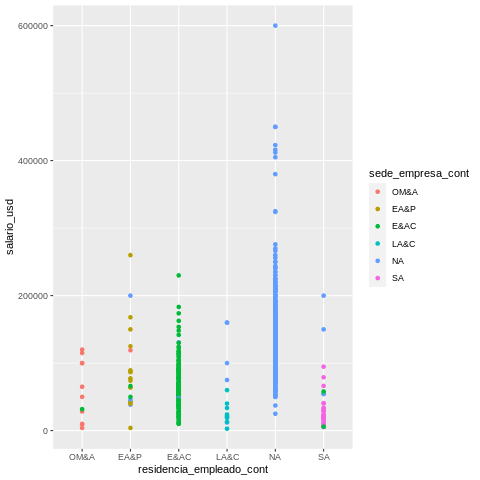

In [ ]:
%%R
ggplot(salarios, aes(residencia_empleado_cont, salario_usd))+
  geom_point(aes(color = sede_empresa_cont))

En el gráfico se puede confirmar lo que ya se venía observando en analisis anteriores, los trabajadores de Norteamerica tienden a trabajar en empresas de la misma región donde también los sueldos son de los más altos, también se observan varias observaciones de trabajadores que optan por trabajar en este país aunque no residen allí, sucede algo similar también con la región europea & Asia central, en estos paises ningún trabajador opta por trabajar fuera de su región. No sucede esto en las regiones restantes donde siempre hay al menos un trabajador que trabaja fuera de su región en Europa & Asia central o en Norteamérica.

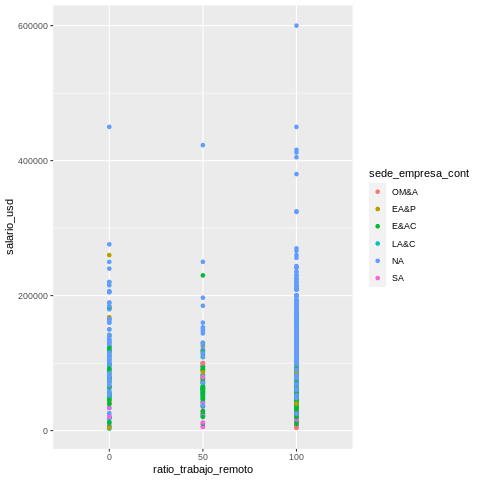

In [ ]:
%%R
ggplot(salarios, aes(ratio_trabajo_remoto, salario_usd))+
  geom_point(aes(color = sede_empresa_cont))

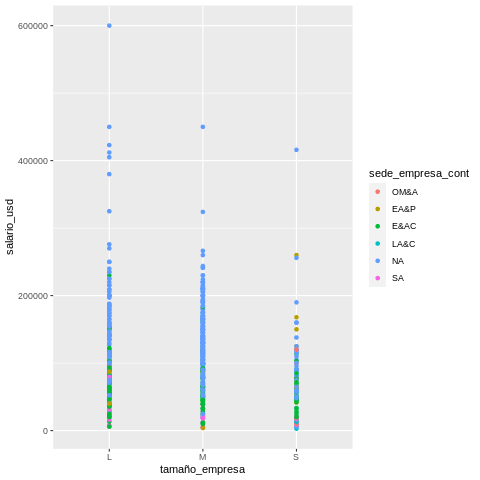

In [ ]:
%%R
ggplot(salarios, aes(tamaño_empresa, salario_usd))+
  geom_point(aes(color = sede_empresa_cont))

Algo similar a lo que sucede con el ratio de trabajo remoto sucede también con el tamaño de la empresa, pareciera que la mayoría de empresas en Norteamérica son de tamaño grande y mediano, lo que sesga los salarios a mayores cantidades que en el caso de las pequeñas.

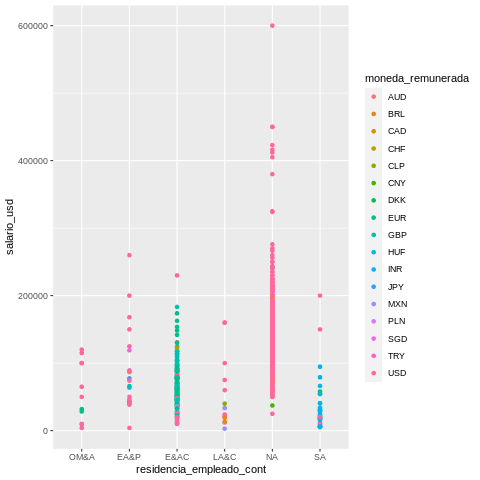

In [ ]:
%%R
ggplot(salarios, aes(residencia_empleado_cont, salario_usd))+
  geom_point(aes(color = moneda_remunerada))

In [ ]:
%%R
ggplot(salarios, aes(residencia_empleado_cont, salario_usd))+
  geom_point(aes(color = moneda_remunerada))